# PLOTS CalCOFI Temperature with GLORYS and NEP 

In [432]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# Any import of metpy will activate the accessors
import pandas as pd
import scipy
import cmocean
import cartopy
import cartopy.crs as ccrs
import math
import cmaps
import cftime
import matplotlib.dates as mdates
import utils


In [433]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("/home/ghervieux/SCRIPTS/PSANCT/cma.mplstyle")

# Define variables, directory


In [434]:

dirin=f'/data/ghervieux/NG_NMS'
var='Temp'
units='$\degree$C'
cruise='ACCESS'


# Define ACCESS line between lines 2, 4, 6

In [435]:
iline=6

# READ Temperature file 
Model fields have been interpolated to obs stations and subsampled in time.

In [436]:
DS=xr.open_dataset(f'{dirin}/{cruise}_{iline}_{var}.nc')
df=DS['time']

print(df)

<xarray.DataArray 'time' (time: 324)>
array(['1993-01-15T00:00:00.000000000', '1993-02-15T00:00:00.000000000',
       '1993-03-15T00:00:00.000000000', ..., '2019-10-15T00:00:00.000000000',
       '2019-11-15T00:00:00.000000000', '2019-12-15T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1993-01-15 1993-02-15 ... 2019-12-15


In [437]:
DS['depth']

<xarray.DataArray 'depth' (depth: 501)>
array([  0,   1,   2, ..., 498, 499, 500])
Coordinates:
  * depth    (depth) int64 0 1 2 3 4 5 6 7 8 ... 493 494 495 496 497 498 499 500

# READ Density file

In [438]:
DSr=xr.open_dataset(f'{dirin}/{cruise}_{iline}_rho.nc')


# Extract Summer months form files

In [439]:
DSjas=DS.sel(time=DS.time.dt.month.isin([7,8,9]))
dfjas=DSjas['time']
obs=DSjas['obs'].sel(depth=slice(0,200))
glo=DSjas['GLORYS'].sel(depth=slice(0,200))
nep=DSjas['NEP'].sel(depth=slice(0,200))

DSrjas=DSr.sel(time=DSr.time.dt.month.isin([7,8,9]))

obsr=DSrjas['obs'].sel(depth=slice(0,200))
glor=DSrjas['GLORYS'].sel(depth=slice(0,200))
nepr=DSrjas['NEP'].sel(depth=slice(0,200))

obsr=obsr-1000.
glor=glor-1000.
nepr=nepr-1000.

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


# PLOT JAS Taylor Diagram

Select only values present in both models

In [440]:
xxx=np.where(np.isnan(obs.data.flatten())==False)[0]
xxx1=np.where(np.isnan(glo.data.flatten())==False)[0]
xxx2=np.where(np.isnan(nep.data.flatten())==False)[0]
yyy=list(set(set(xxx).intersection(xxx1)).intersection(xxx2))

Flatten arrays

In [441]:
# Reference dataset
dataC=obs.data.flatten()[yyy]
# Generate models
m1C = glo.data.flatten()[yyy]  # Model 1
m2C = nep.data.flatten()[yyy]  # Model 2

Compute stddev and correlation coefficient of models


In [442]:
samples = np.array([ [m.std(ddof=1), np.corrcoef(dataC,m)[0, 1]]
                       for m in (dataC,m1C, m2C)])

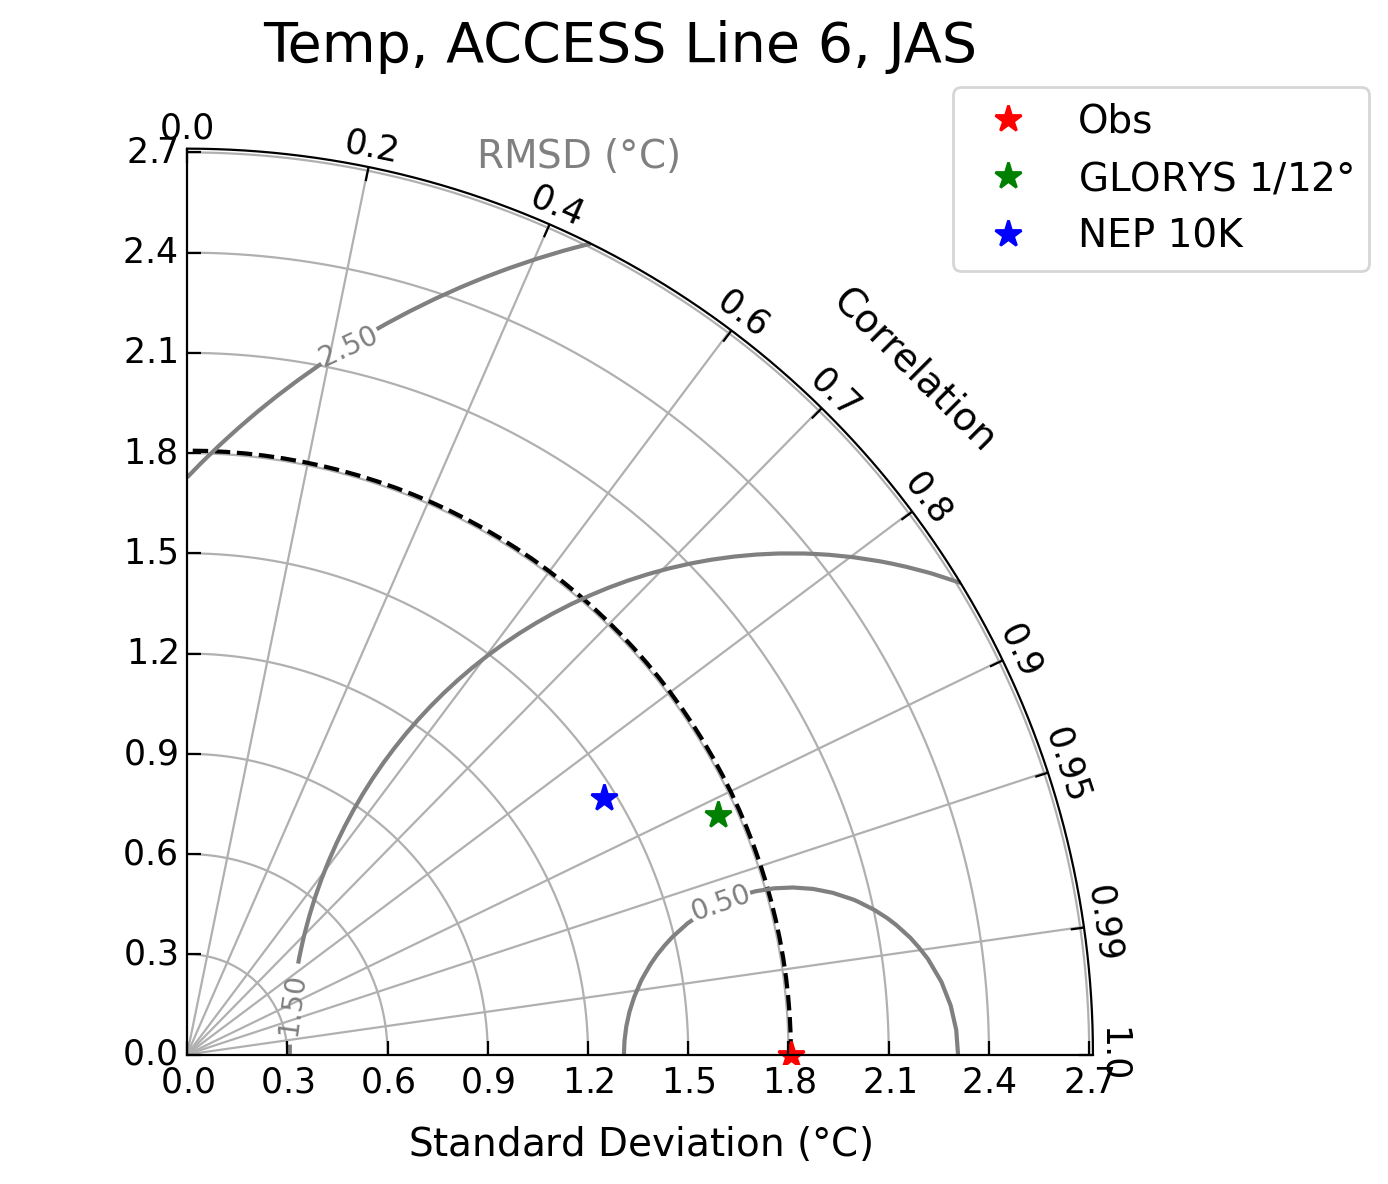

In [443]:
fig,axs = plt.subplots(nrows=1,ncols=1)
dia = utils.TaylorDiagram(samples[0,0], fig=fig, rect=111, label="",
                    srange=(0., 1.5))

colors = ['red','green','blue']
labels = ["Obs",'GLORYS $1/12\degree$','NEP 10K']
# Add the models to Taylor diagram
for i, (stddev, corrcoef) in enumerate(samples):
  dia.add_sample(stddev, corrcoef, \
                    marker='*', ms=10, ls='', \
                    mfc=colors[i], mec=colors[i], \
                    label=labels[i])
# Add grid
dia.add_grid()
# Add a figure legend
fig.legend(dia.samplePoints,
            [ p.get_label() for p in dia.samplePoints ],
            numpoints=1, loc='upper right',\
                    bbox_to_anchor=(0.98,0.94), prop={'size': 14})
plt.text(0.5,-0.1,f'Standard Deviation ({units})',c='k',transform=axs.transAxes,\
            ha='center',fontsize=14,rotation=0)
plt.text(0.65,0.75,f'Correlation',c='k',transform=axs.transAxes,\
            va='center',fontsize=14,rotation=315)
plt.text(0.45,0.97,f'RMSD ({units})',c='grey',transform=axs.transAxes,\
            rotation=0,ha='center',fontsize=14)
axs.axis('off')
plt.suptitle(f'{var}, {cruise} Line {iline}, JAS',fontsize=20)
outfile=f'PLOTS/{cruise}_JAS_{var}_line{iline}_TaylorDiagram.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT JAS Scatter Plot

/tmp/ipykernel_3876805/31063134.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)


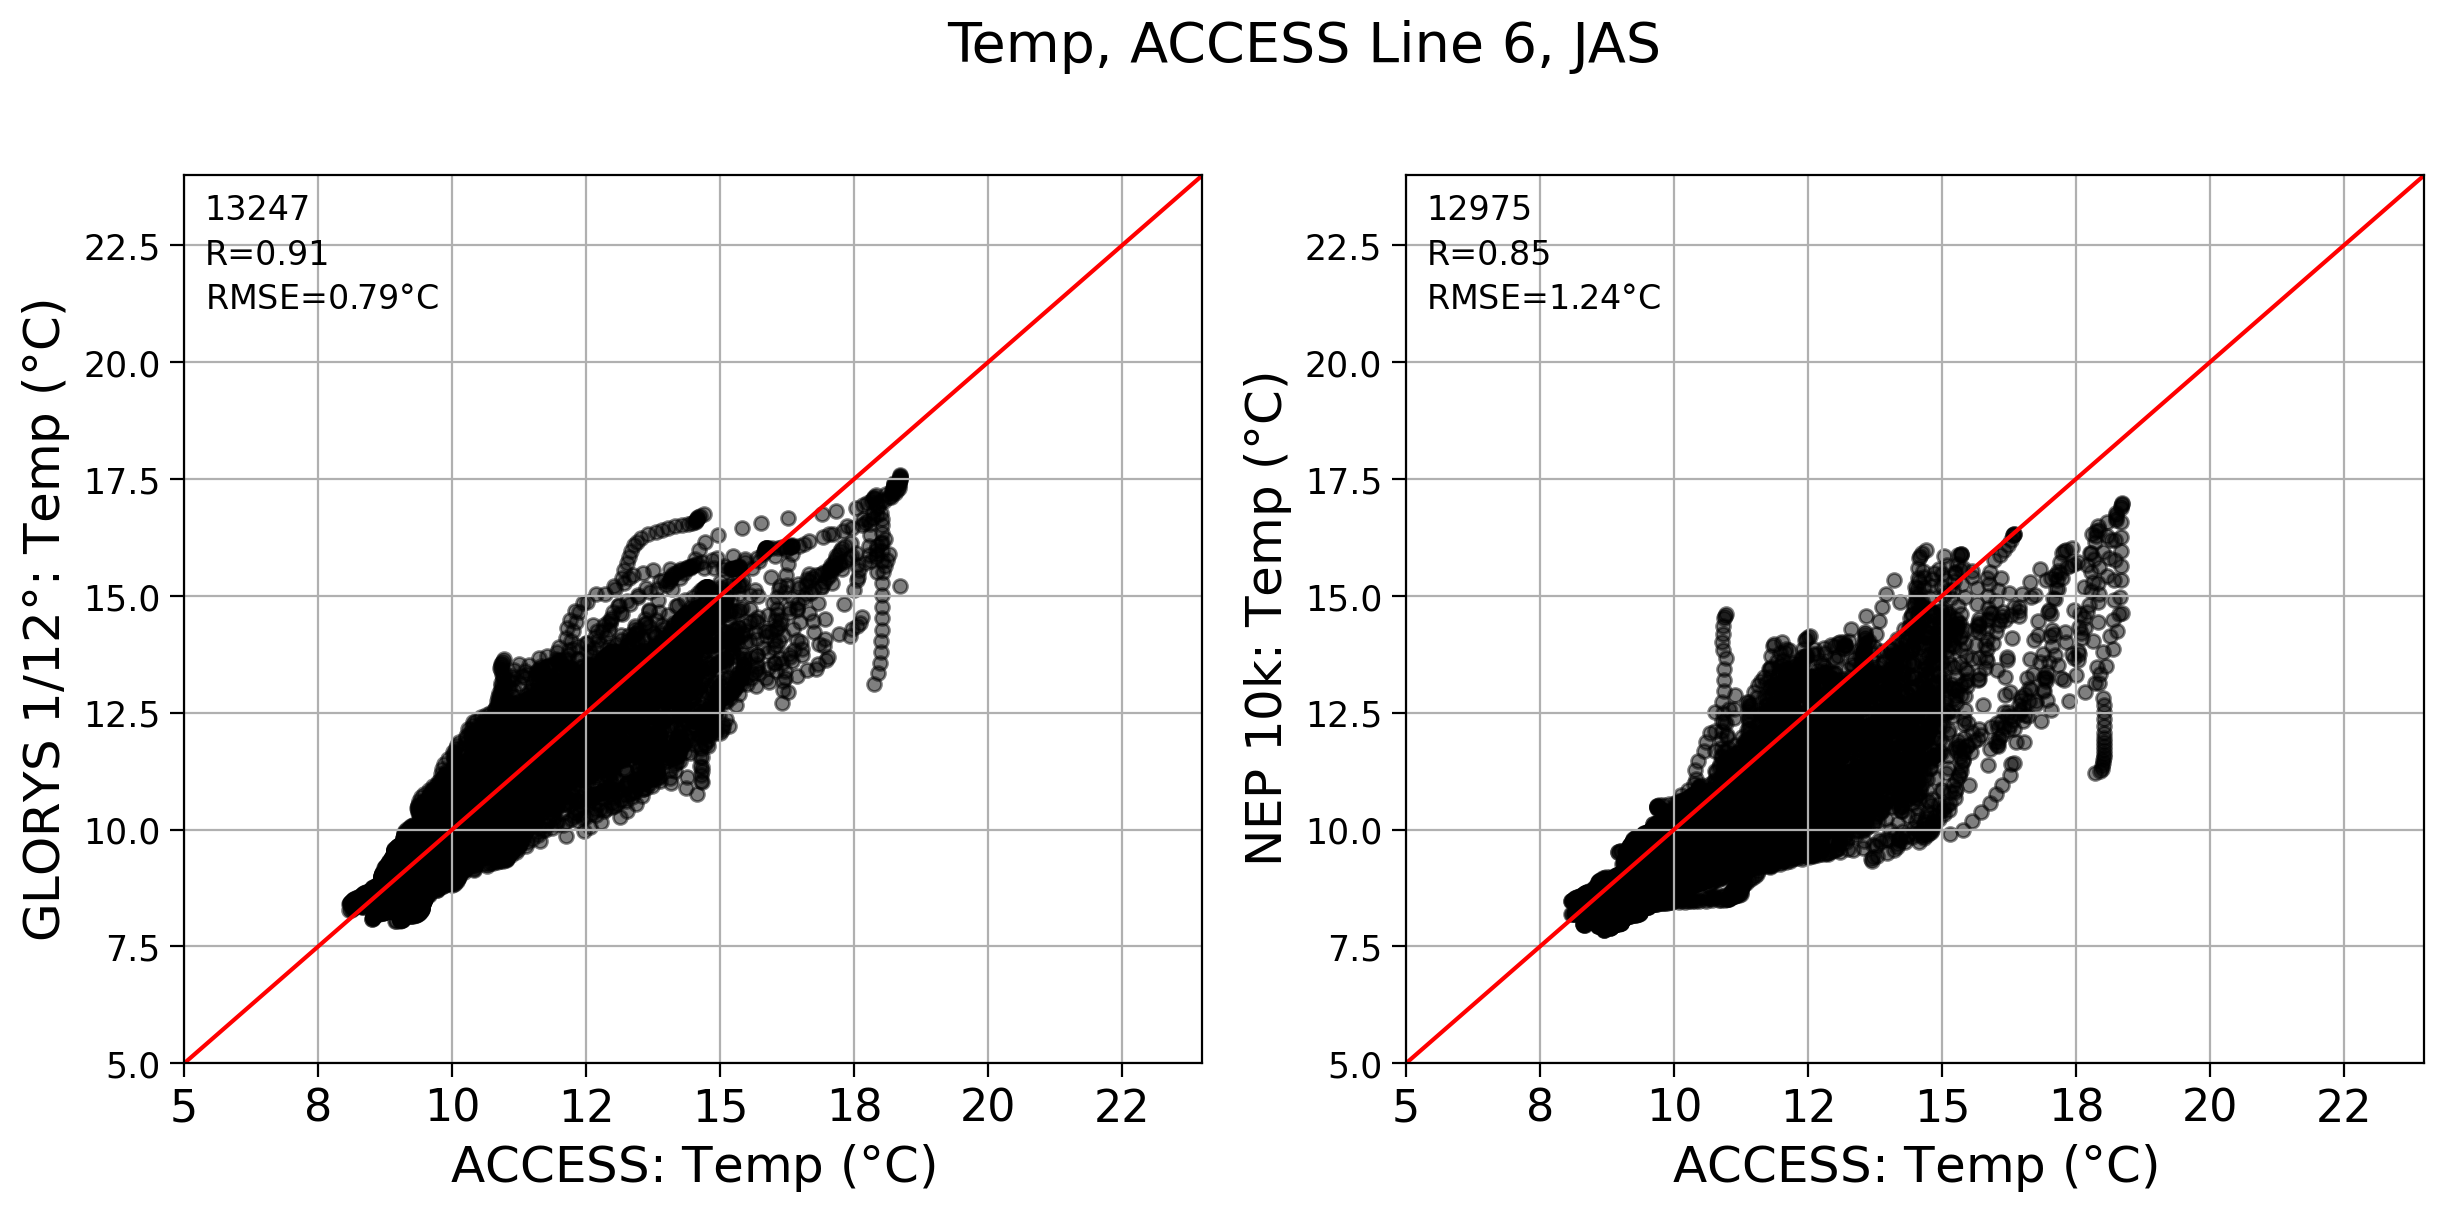

In [444]:
rmse_G=np.round(np.sqrt(((obs-glo)**2).mean().data),2)
rmse_N=np.round(np.sqrt(((obs-nep)**2).mean().data),2)
cor_G=np.round(np.corrcoef(obs.data.flatten()[xxx1],glo.data.flatten()[xxx1])[0][1],2)
cor_N=np.round(np.corrcoef(obs.data.flatten()[xxx2],nep.data.flatten()[xxx2])[0][1],2)

fig, axs =plt.subplots(nrows=1,ncols=2,figsize=(14,6),num=4,clear=True)

plt.subplots_adjust(bottom=0.11, right=0.9,left=0.1,top=0.85,wspace=0.2)

scatter=axs[0].scatter(obs,glo,s=25,c='k',marker='o',alpha=0.5)
scatter=axs[1].scatter(obs,nep,s=25,c='k',marker='o',alpha=0.5)
axs[0].text(0.02, 0.95,f'{len(xxx1)}',transform=axs[0].transAxes,\
            rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.9,f'R={cor_G}',transform=axs[0].transAxes,\
            rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.85,f'RMSE={rmse_G}{units}',transform=axs[0].transAxes,\
            rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.95,f'{len(xxx2)}',transform=axs[1].transAxes,\
            rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.90,f'R={cor_N}',transform=axs[1].transAxes,\
            rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.85,f'RMSE={rmse_N}{units}',transform=axs[1].transAxes,\
            rotation='horizontal',fontsize=12)

for i in range(len(axs)):
    axs[i].set_ylim(5,24)
    axs[i].set_xlim(5,24)
    axs[i].grid()
    axs[i].plot(np.arange(1,30,1),np.arange(1,30,1),color='red')
    axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
    axs[i].set_xlabel(f'{cruise}: {var} ({units})',fontsize=18)

axs[0].set_ylabel(f'GLORYS 1/12$\degree$: {var} ({units})',fontsize=18)
axs[1].set_ylabel(f'NEP 10k: {var} ({units})',fontsize=18)

plt.suptitle(f'{var}, {cruise} Line {iline}, JAS',fontsize=20)
outfile=f'PLOTS/{cruise}_JAS_{var}_line{iline}_Scatter.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# PLOT JAS Section

Define colormaps and plotting levels

In [445]:
cmap='cmo.thermal'
#
clevs=np.arange(2,17,1)# Mean var
clevsa=np.arange(-3,3.2,0.2) # Mean var anomaly
clevss=np.arange(0,2.15,0.15)# Std var
clevssa=np.arange(-3.,3.2,0.2)# Std var anomaly
#
clevd=np.arange(23,27.5,0.2) # Mean rho 
clevda=np.arange(-0.3,0.35,0.05) # Mean rho anomaly
clevds=np.arange(0,0.65,0.05)# STD rho

Interpolate linearly through depth 

In [446]:
meanC=obs.interpolate_na(dim='depth',method='linear').mean('time')
meanCr=obsr.interpolate_na(dim='depth',method='linear').mean('time')
meanG=glo.interpolate_na(dim='depth',method='linear').mean('time')
meanGr=glor.interpolate_na(dim='depth',method='linear').mean('time')
meanN=nep.interpolate_na(dim='depth',method='linear').mean('time')
meanNr=nepr.interpolate_na(dim='depth',method='linear').mean('time')
stdC=obs.interpolate_na(dim='depth',method='linear').std('time')
stdCr=obsr.interpolate_na(dim='depth',method='linear').std('time')
stdG=glo.interpolate_na(dim='depth',method='linear').std('time')
stdGr=glor.interpolate_na(dim='depth',method='linear').std('time')
stdN=nep.interpolate_na(dim='depth',method='linear').std('time')
stdNr=nepr.interpolate_na(dim='depth',method='linear').std('time')

dep=obs.depth

In [447]:
##### Define distance to the coast
crossD=np.zeros((len(DS['npts'])))
for il in range(0,len(DS['npts'])):
    crossD[il]=round(utils.distance((DS['latitude'][il],DS['longitude'][il]),
                               (DS['latitude'][0],DS['longitude'][0])))

JAS Mean var  

/tmp/ipykernel_3876805/3390202322.py:6: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  cs = axs[0].contourf(-crossD[:],-dep,meanC,levels=clevs,extend='max',cmap=cmap,add_colorbar = False)
/tmp/ipykernel_3876805/3390202322.py:9: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  cs = axs[3].contourf(-crossD,-dep,meanC,levels=clevs,extend='max',cmap=cmap,add_colorbar = False)
/tmp/ipykernel_3876805/3390202322.py:13: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  cs = axs[1].contourf(-crossD,-dep,meanN,levels=clevs,extend='max',cmap=cmap,add_colorbar = False)
/tmp/ipykernel_3876805/3390202322.py:16: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  cs = axs[4].contourf(-crossD,-dep,meanN,levels=clevs,extend='max',cmap=cmap,add_colorbar = False)
/tmp/ipykernel_3876805/3390202322.py:20: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  cs = axs[2].conto

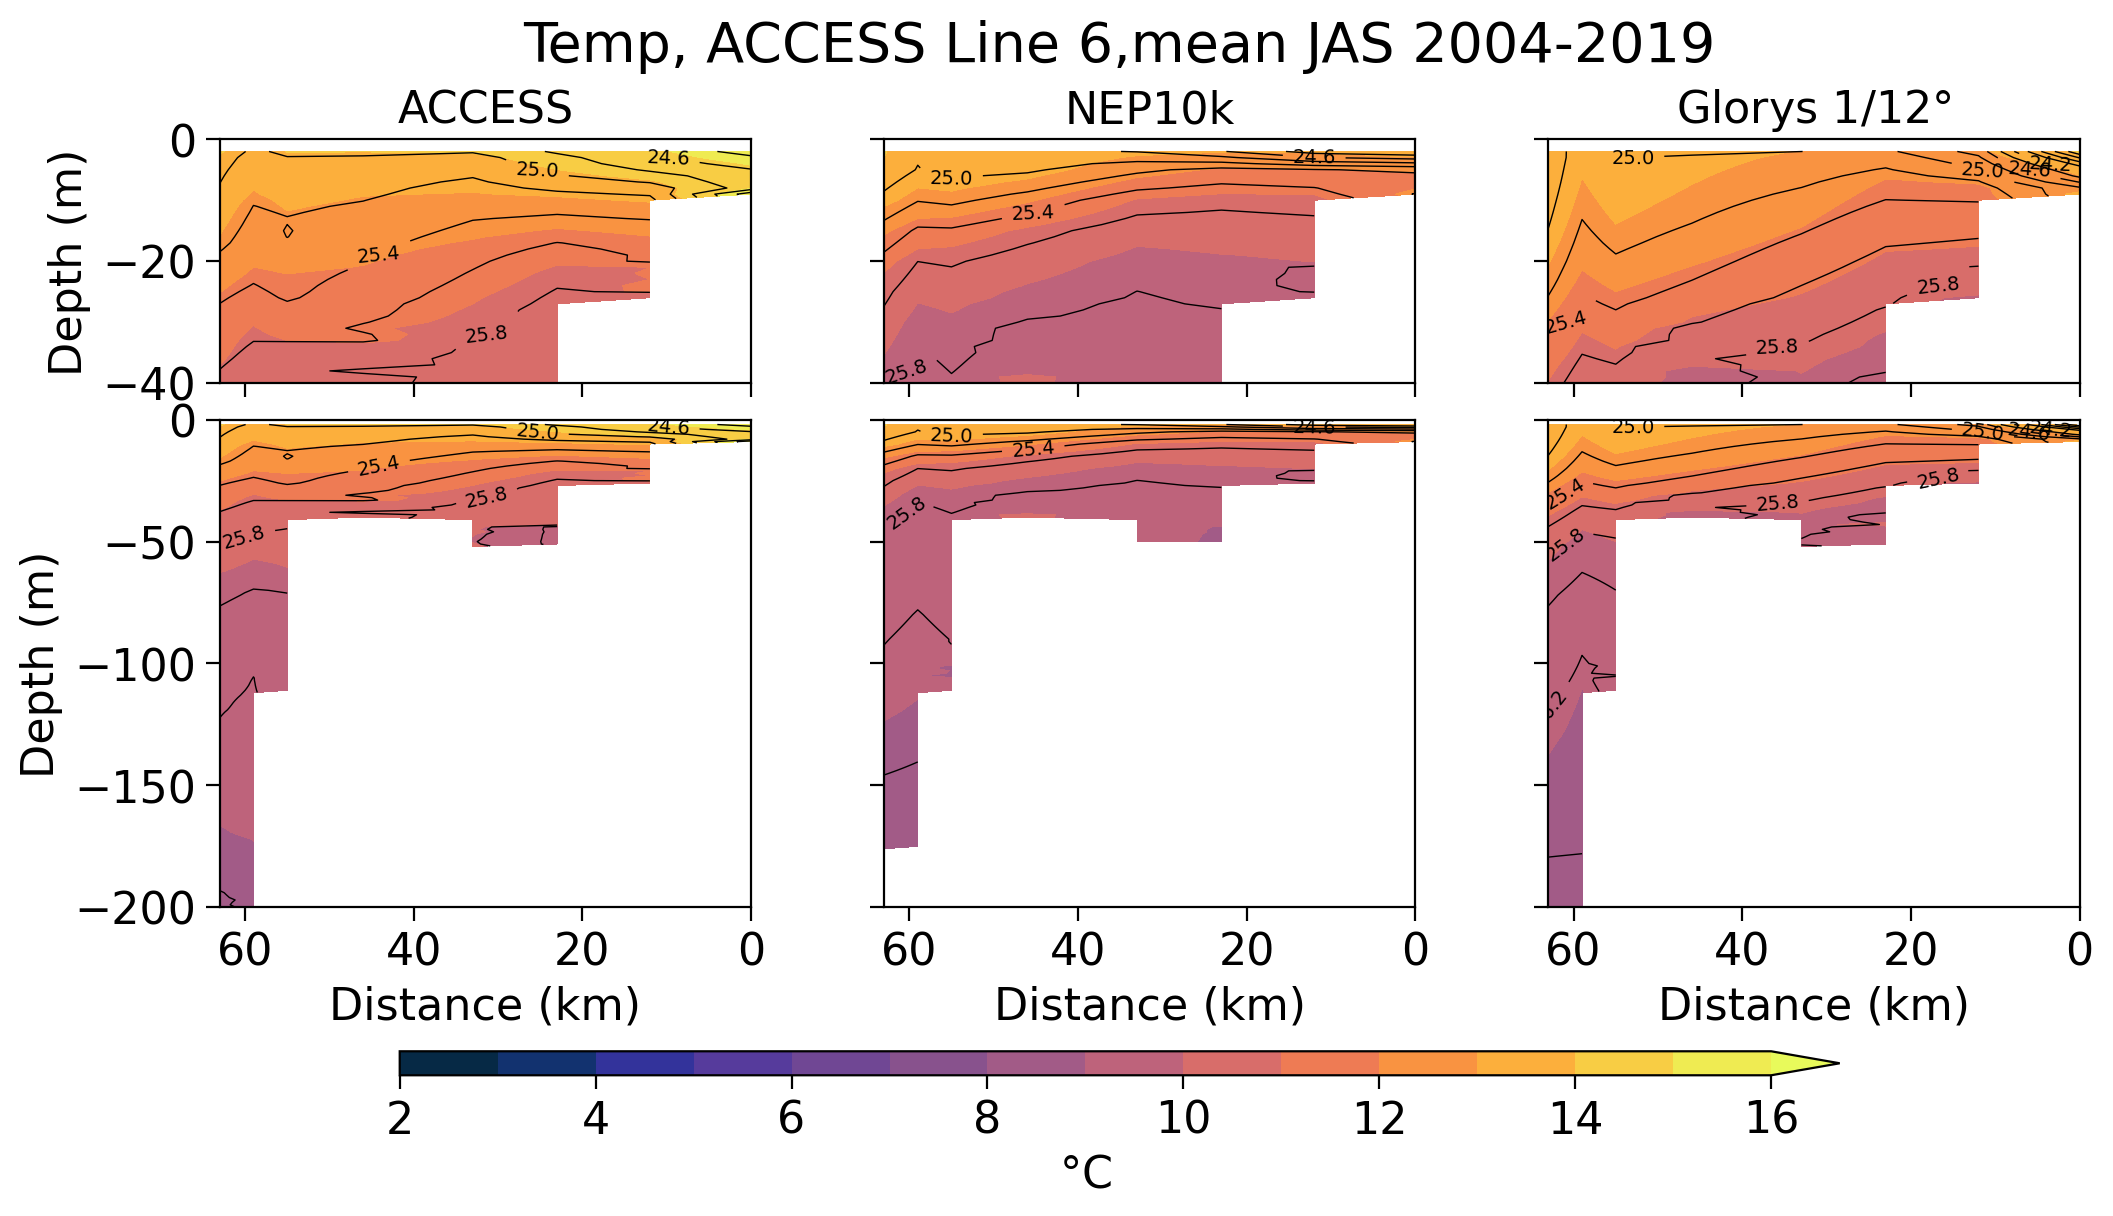

In [448]:
fig,axs=plt.subplots(nrows=2,ncols=3,gridspec_kw={'height_ratios':[3,6]},
                        figsize=(12,6))
plt.subplots_adjust(bottom=0.24, right=0.9, top=0.88,hspace=0.1,wspace=0.25)
axs=axs.flatten()
### Plot the path of the cross section ###
cs = axs[0].contourf(-crossD[:],-dep,meanC,levels=clevs,extend='max',cmap=cmap,add_colorbar = False)
cc =axs[0].contour(-crossD,-dep,meanCr,levels=clevd,extend='max',colors='k',linewidths=0.5)
axs[0].clabel(cc,cc.levels[::2],inline=True, fmt='%1.1f',fontsize=7)
cs = axs[3].contourf(-crossD,-dep,meanC,levels=clevs,extend='max',cmap=cmap,add_colorbar = False)
cc =axs[3].contour(-crossD,-dep,meanCr,levels=clevd,extend='max',colors='k',linewidths=0.5)
axs[3].clabel(cc,cc.levels[::2],inline=True, fmt='%1.1f',fontsize=7)
axs[0].set_title(f'{cruise}',fontsize=16)
cs = axs[1].contourf(-crossD,-dep,meanN,levels=clevs,extend='max',cmap=cmap,add_colorbar = False)
cc=axs[1].contour(-crossD,-dep,meanNr,levels=clevd,extend='max',colors='k',linewidths=0.5)
axs[1].clabel(cc,cc.levels[::2],inline=True, fmt='%1.1f',fontsize=7)
cs = axs[4].contourf(-crossD,-dep,meanN,levels=clevs,extend='max',cmap=cmap,add_colorbar = False)
cc=axs[4].contour(-crossD,-dep,meanNr,levels=clevd,extend='max',colors='k',linewidths=0.5)
axs[4].clabel(cc,cc.levels[::2],inline=True, fmt='%1.1f',fontsize=7)
axs[1].set_title('NEP10k',fontsize=16)
cs = axs[2].contourf(-crossD,-dep,meanG,levels=clevs,extend='max',cmap=cmap,add_colorbar = False)
cc=axs[2].contour(-crossD,-dep,meanGr,levels=clevd,extend='max',colors='k',linewidths=0.5)
axs[2].clabel(cc,cc.levels[::2],inline=True, fmt='%1.1f',fontsize=7)
cs = axs[5].contourf(-crossD,-dep,meanG,levels=clevs,extend='max',cmap=cmap,add_colorbar = False)
cc=axs[5].contour(-crossD,-dep,meanGr,levels=clevd,extend='max',colors='k',linewidths=0.5)
axs[5].clabel(cc,cc.levels[::2],inline=True, fmt='%1.1f',fontsize=7)
axs[2].set_title('Glorys $1/12\degree$',fontsize=16)
for ix in range(0,len(axs)):
    axs[ix].set_ylabel('')
    axs[ix].set_xlabel('')
    if ix<3:
      axs[ix].set_ylim(-40,0)
      axs[ix].set_xticklabels([''])
      axs[ix].set_xlabel('',size=12)
    else:
      axs[ix].set_ylim(-200,0)
      axs[ix].set_xticklabels([f'{int(abs(ixx))}' \
    for ixx in axs[ix].get_xticks()[:]],fontsize=16)
      axs[ix].set_xlabel('Distance (km)',size=16)
    if (ix==0) | (ix==3):
      axs[ix].yaxis.set_tick_params(labelsize=16)
      axs[ix].set_ylabel('Depth (m)',size=16)
    else:
      axs[ix].set_yticklabels([''])
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle(f'{var}, {cruise} Line {iline},mean JAS 2004-2019',fontsize=20)
outfile=f'PLOTS/{cruise}_JAS_{var}_line{iline}_Xsection.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

JAS Mean Anomaly var

/tmp/ipykernel_3876805/4020450682.py:6: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  =axs[0].contourf(-crossD,-dep,meanC,levels=clevs,extend='both',cmap=cmap,add_colorbar = False)
/tmp/ipykernel_3876805/4020450682.py:9: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  axs[3].contourf(-crossD,-dep,meanC,levels=clevs,extend='both',cmap=cmap,add_colorbar = False)
/tmp/ipykernel_3876805/4020450682.py:13: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  cas=axs[1].contourf(-crossD,-dep,meanN-meanC,levels=clevsa,extend='both',cmap=cmaps.ncl_default,add_colorbar = False)
/tmp/ipykernel_3876805/4020450682.py:16: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  axs[4].contourf(-crossD,-dep,meanN-meanC,levels=clevsa,extend='both',cmap=cmaps.ncl_default,add_colorbar = False)
/tmp/ipykernel_3876805/4020450682.py:20: UserWarning: The following kwargs were not used by contour: 'add_col

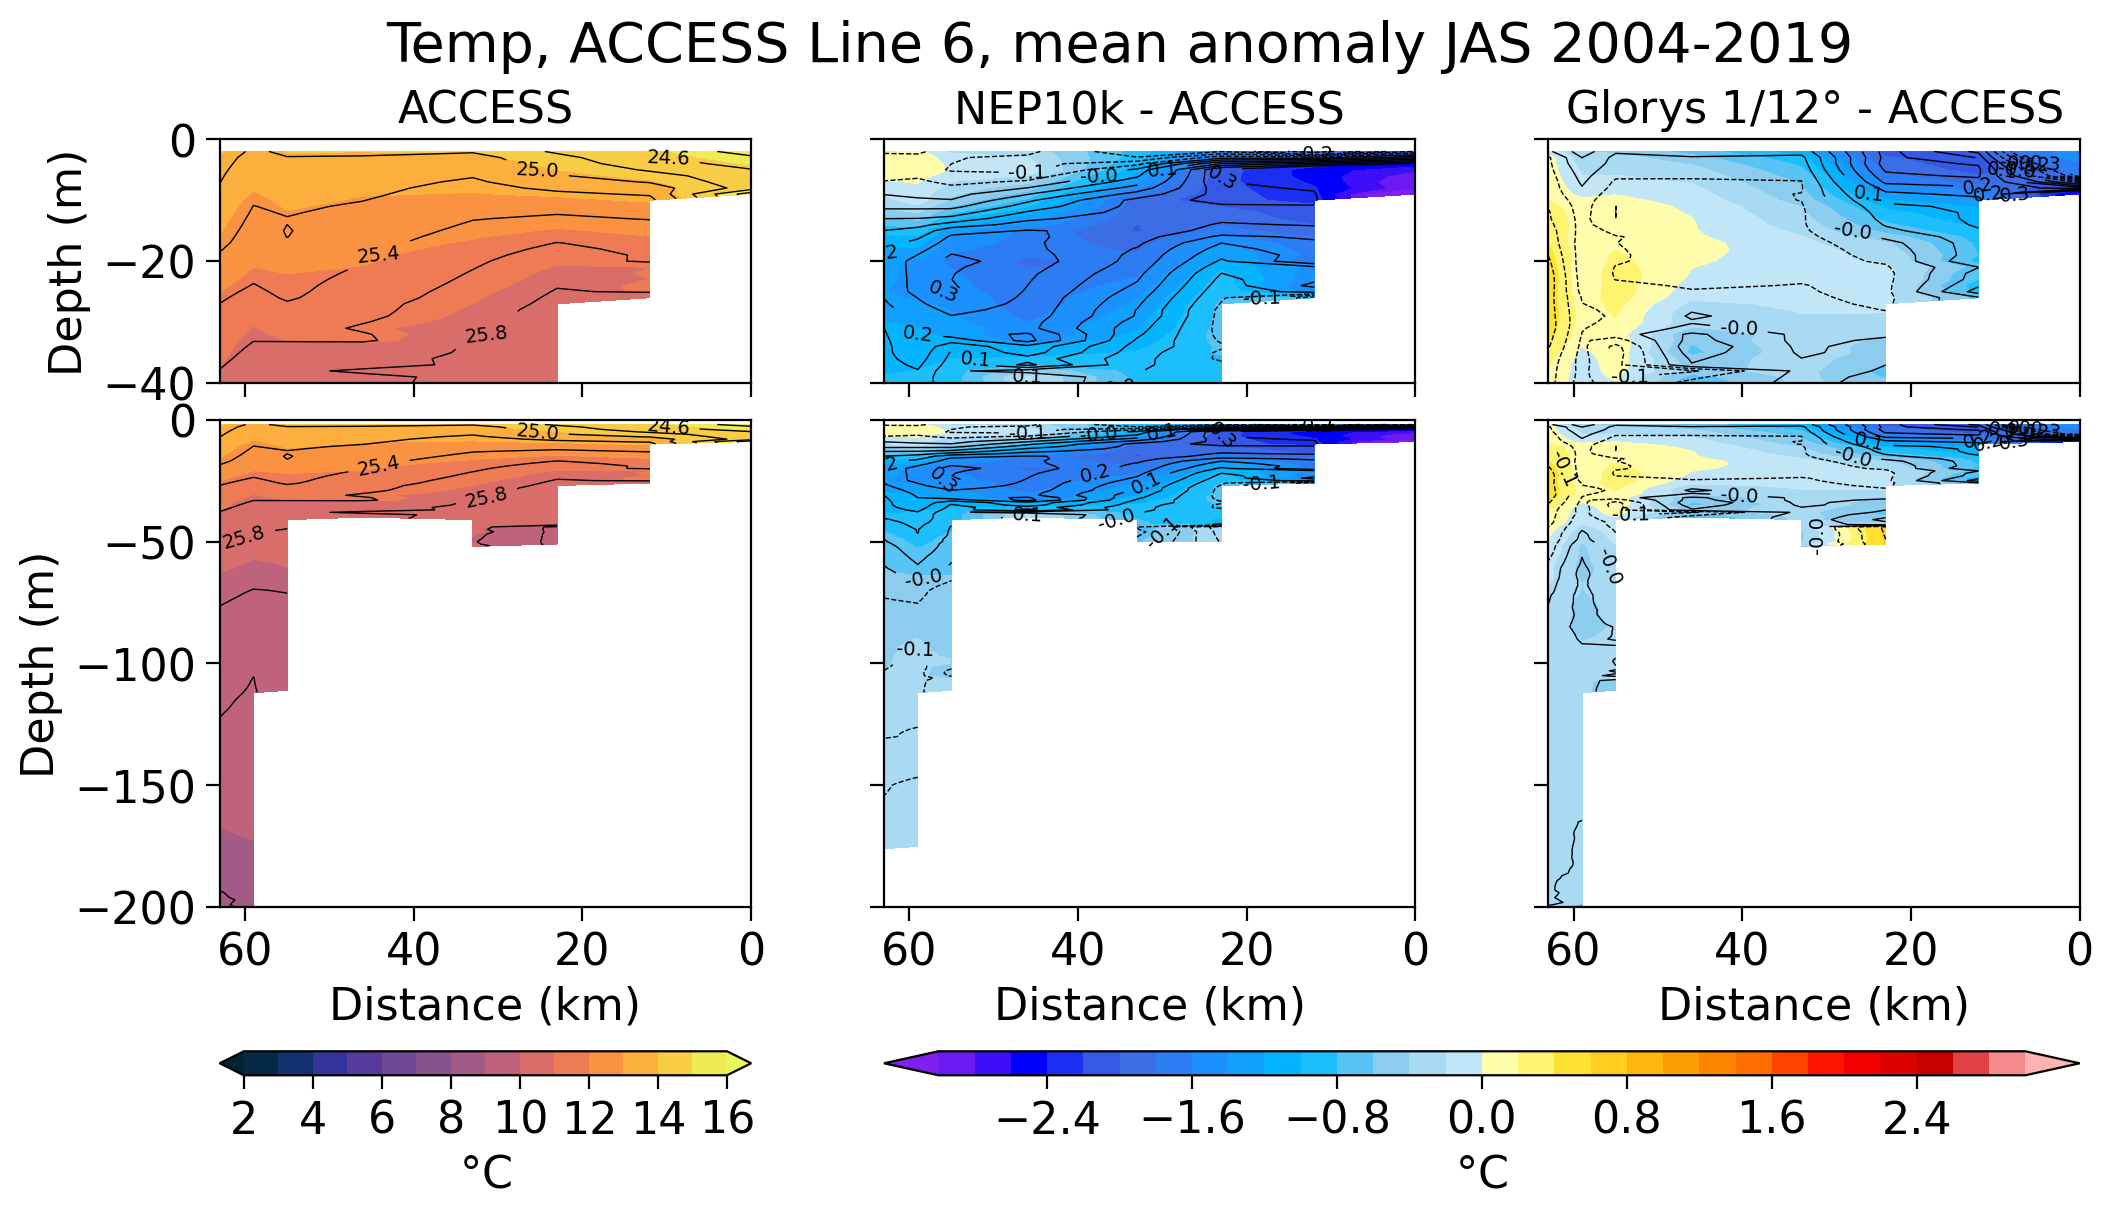

In [449]:
fig, axs =plt.subplots(nrows=2,ncols=3,gridspec_kw={'height_ratios':[3,6]},
                    figsize=(12,6),num=3,clear=True)
plt.subplots_adjust(bottom=0.24, right=0.9, top=0.88,hspace=0.1,wspace=0.25)
axs=axs.flatten()
cs\
=axs[0].contourf(-crossD,-dep,meanC,levels=clevs,extend='both',cmap=cmap,add_colorbar = False)
cc =axs[0].contour(-crossD,-dep,meanCr,levels=clevd,extend='max',colors='k',linewidths=0.5)
axs[0].clabel(cc,cc.levels[::2],inline=True, fmt='%1.1f',fontsize=7)
axs[3].contourf(-crossD,-dep,meanC,levels=clevs,extend='both',cmap=cmap,add_colorbar = False)
cc =axs[3].contour(-crossD,-dep,meanCr,levels=clevd,extend='max',colors='k',linewidths=0.5)
axs[3].clabel(cc,cc.levels[::2],inline=True, fmt='%1.1f',fontsize=7)
axs[0].set_title(f'{cruise}',fontsize=16)
cas=axs[1].contourf(-crossD,-dep,meanN-meanC,levels=clevsa,extend='both',cmap=cmaps.ncl_default,add_colorbar = False)
cc =axs[1].contour(-crossD,-dep,meanNr-meanCr,levels=clevda,extend='max',colors='k',linewidths=0.5)
axs[1].clabel(cc,cc.levels[::2],inline=True, fmt='%1.1f',fontsize=7)
axs[4].contourf(-crossD,-dep,meanN-meanC,levels=clevsa,extend='both',cmap=cmaps.ncl_default,add_colorbar = False)
cc =axs[4].contour(-crossD,-dep,meanNr-meanCr,levels=clevda,extend='max',colors='k',linewidths=0.5)
axs[4].clabel(cc,cc.levels[::2],inline=True, fmt='%1.1f',fontsize=7)
axs[1].set_title(f'NEP10k - {cruise}',fontsize=16)
axs[2].contourf(-crossD,-dep,meanG-meanC,levels=clevsa,extend='both',cmap=cmaps.ncl_default,add_colorbar = False)
cc =axs[2].contour(-crossD,-dep,meanGr-meanCr,levels=clevda,extend='max',colors='k',linewidths=0.5)
axs[2].clabel(cc,cc.levels[::2],inline=True, fmt='%1.1f',fontsize=7)
axs[5].contourf(-crossD,-dep,meanG-meanC,levels=clevsa,extend='both',cmap=cmaps.ncl_default,add_colorbar = False)
cc =axs[5].contour(-crossD,-dep,meanGr-meanCr,levels=clevda,extend='max',colors='k',linewidths=0.5)
axs[5].clabel(cc,cc.levels[::2],inline=True, fmt='%1.1f',fontsize=7)
axs[2].set_title(f'Glorys $1/12\degree$ - {cruise}',fontsize=16)
for ix in range(0,len(axs)):
    axs[ix].set_ylabel('')
    axs[ix].set_xlabel('')
    if ix<3:
      axs[ix].set_ylim(-40,0)
      axs[ix].set_xticklabels([''])
      axs[ix].set_xlabel('',size=12)
    else:
      axs[ix].set_ylim(-200,0)
      axs[ix].set_xticklabels([f'{int(abs(ixx))}' \
    for ixx in axs[ix].get_xticks()[:]],fontsize=16)
      axs[ix].set_xlabel('Distance (km)',size=16)
    if (ix==0) | (ix==3):
      axs[ix].yaxis.set_tick_params(labelsize=16)
      axs[ix].set_ylabel('Depth (m)',size=16)
    else:
      axs[ix].set_yticklabels([''])
p0 = axs[0].get_position().get_points().flatten()
cbar_ax=fig.add_axes([p0[0], 0.1, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label=units)
cbar.ax.set_yticks(cbar.ax.get_yticks()[::2])
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
p0 = axs[1].get_position().get_points().flatten()
p1 = axs[2].get_position().get_points().flatten()
cbar_ax=fig.add_axes([p0[0], 0.1, p1[2]-p0[0], 0.02])
cbar=fig.colorbar(cas, cax=cbar_ax,orientation='horizontal',label=units)
cbar.ax.set_yticks(cbar.ax.get_yticks()[::2])#,labelsize=12)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle(f'{var}, {cruise} Line {iline}, mean anomaly JAS 2004-2019',fontsize=20)
outfile=f'PLOTS/{cruise}_JAS_A{var}_line{iline}_Xsection.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

JAS STD var

/tmp/ipykernel_3876805/3001103089.py:6: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  axs[0].contourf(-crossD,-dep,stdC,levels=clevss,extend='max',cmap='cmo.thermal',add_colorbar = False)
/tmp/ipykernel_3876805/3001103089.py:10: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  axs[3].contourf(-crossD,-dep,stdC,levels=clevss,extend='max',cmap='cmo.thermal',add_colorbar = False)
/tmp/ipykernel_3876805/3001103089.py:14: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  cs =axs[1].contourf(-crossD,-dep,stdN,levels=clevss,extend='max',cmap='cmo.thermal',add_colorbar = False)
/tmp/ipykernel_3876805/3001103089.py:17: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  axs[4].contourf(-crossD,-dep,stdN,levels=clevss,extend='max',cmap='cmo.thermal',add_colorbar = False)
/tmp/ipykernel_3876805/3001103089.py:21: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
 

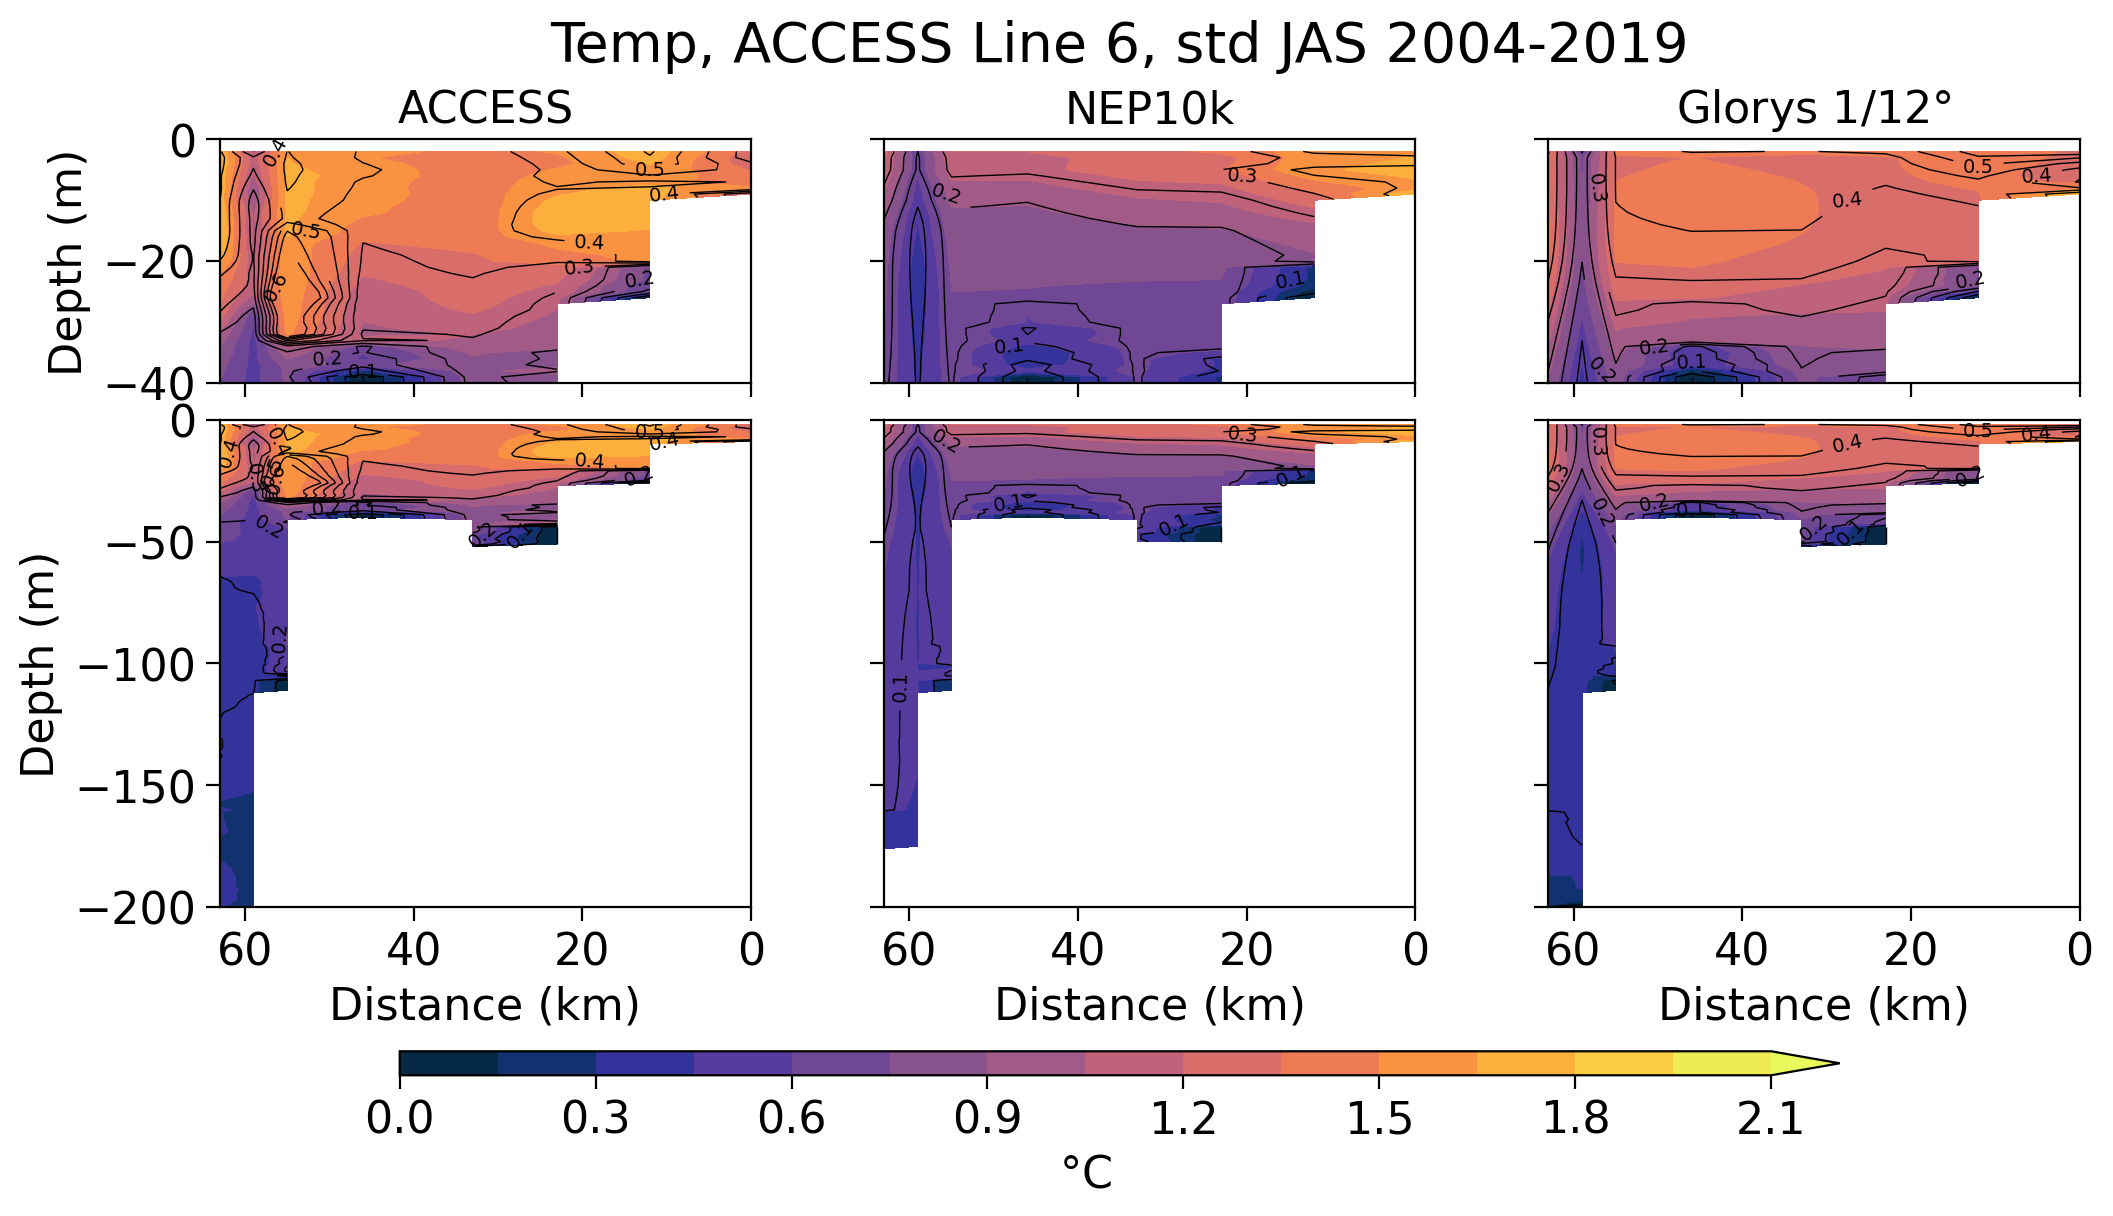

In [450]:
fig,axs=plt.subplots(nrows=2,ncols=3,gridspec_kw={'height_ratios':[3,6]},
                    figsize=(12,6),num=3,clear=True)
plt.subplots_adjust(bottom=0.24, right=0.9, top=0.88,hspace=0.1,wspace=0.25)
axs=axs.flatten()
cs =\
axs[0].contourf(-crossD,-dep,stdC,levels=clevss,extend='max',cmap='cmo.thermal',add_colorbar = False)
cc =axs[0].contour(-crossD,-dep,stdCr,levels=clevds,extend='max',colors='k',linewidths=0.5)
axs[0].clabel(cc,cc.levels[::2],inline=True, fmt='%1.1f',fontsize=7)
cs = \
axs[3].contourf(-crossD,-dep,stdC,levels=clevss,extend='max',cmap='cmo.thermal',add_colorbar = False)
cc =axs[3].contour(-crossD,-dep,stdCr,levels=clevds,extend='max',colors='k',linewidths=0.5)
axs[3].clabel(cc,cc.levels[::2],inline=True, fmt='%1.1f',fontsize=7)
axs[0].set_title(f'{cruise}',fontsize=16)
cs =axs[1].contourf(-crossD,-dep,stdN,levels=clevss,extend='max',cmap='cmo.thermal',add_colorbar = False)
cc =axs[1].contour(-crossD,-dep,stdNr,levels=clevds,extend='max',colors='k',linewidths=0.5)
axs[1].clabel(cc,cc.levels[::2],inline=True, fmt='%1.1f',fontsize=7)
axs[4].contourf(-crossD,-dep,stdN,levels=clevss,extend='max',cmap='cmo.thermal',add_colorbar = False)
cc =axs[4].contour(-crossD,-dep,stdNr,levels=clevds,extend='max',colors='k',linewidths=0.5)
axs[4].clabel(cc,cc.levels[::2],inline=True, fmt='%1.1f',fontsize=7)
axs[1].set_title('NEP10k',fontsize=16)
axs[2].contourf(-crossD,-dep,stdG,levels=clevss,extend='max',cmap='cmo.thermal',add_colorbar = False)
cc =axs[2].contour(-crossD,-dep,stdGr,levels=clevds,extend='max',colors='k',linewidths=0.5)
axs[2].clabel(cc,cc.levels[::2],inline=True, fmt='%1.1f',fontsize=7)
axs[5].contourf(-crossD,-dep,stdG,levels=clevss,extend='max',cmap='cmo.thermal',add_colorbar = False)
cc =axs[5].contour(-crossD,-dep,stdGr,levels=clevds,extend='max',colors='k',linewidths=0.5)
axs[5].clabel(cc,cc.levels[::2],inline=True, fmt='%1.1f',fontsize=7)
axs[2].set_title('Glorys $1/12\degree$',fontsize=16)
for ix in range(0,len(axs)):
    axs[ix].set_ylabel('')
    axs[ix].set_xlabel('')
    if ix<3:
      axs[ix].set_ylim(-40,0)
      axs[ix].set_xticklabels([''])
      axs[ix].set_xlabel('',size=12)
    else:
      axs[ix].set_ylim(-200,0)
      axs[ix].set_xticklabels([f'{int(abs(ixx))}' \
          for ixx in axs[ix].get_xticks()[:]],fontsize=16)
      axs[ix].set_xlabel('Distance (km)',size=16)
    if (ix==0) | (ix==3):
      axs[ix].yaxis.set_tick_params(labelsize=16)
      axs[ix].set_ylabel('Depth (m)',size=16)
    else:
      axs[ix].set_yticklabels([''])
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label=units)
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle(f'{var}, {cruise} Line {iline}, std JAS 2004-2019',fontsize=20)
outfile=f'PLOTS/{cruise}_JAS_STD{var}_line{iline}_Xsection.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

JAS STD anomaly var

/tmp/ipykernel_3876805/503192505.py:6: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  axs[0].contourf(-crossD,-dep,stdC,levels=clevss,extend='both',cmap='cmo.thermal',add_colorbar = False)
/tmp/ipykernel_3876805/503192505.py:8: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  axs[3].contourf(-crossD,-dep,stdC,levels=clevss,extend='both',cmap='cmo.thermal',add_colorbar = False)
/tmp/ipykernel_3876805/503192505.py:10: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  cas=axs[1].contourf(-crossD,-dep,(meanN-meanC)/stdC,levels=clevssa,extend='both',cmap=cmaps.ncl_default,add_colorbar = False)
/tmp/ipykernel_3876805/503192505.py:11: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  cas=axs[4].contourf(-crossD,-dep,(meanN-meanC)/stdC,levels=clevssa,extend='both',cmap=cmaps.ncl_default,add_colorbar = False)
/tmp/ipykernel_3876805/503192505.py:13: UserWarning: The following kwargs we

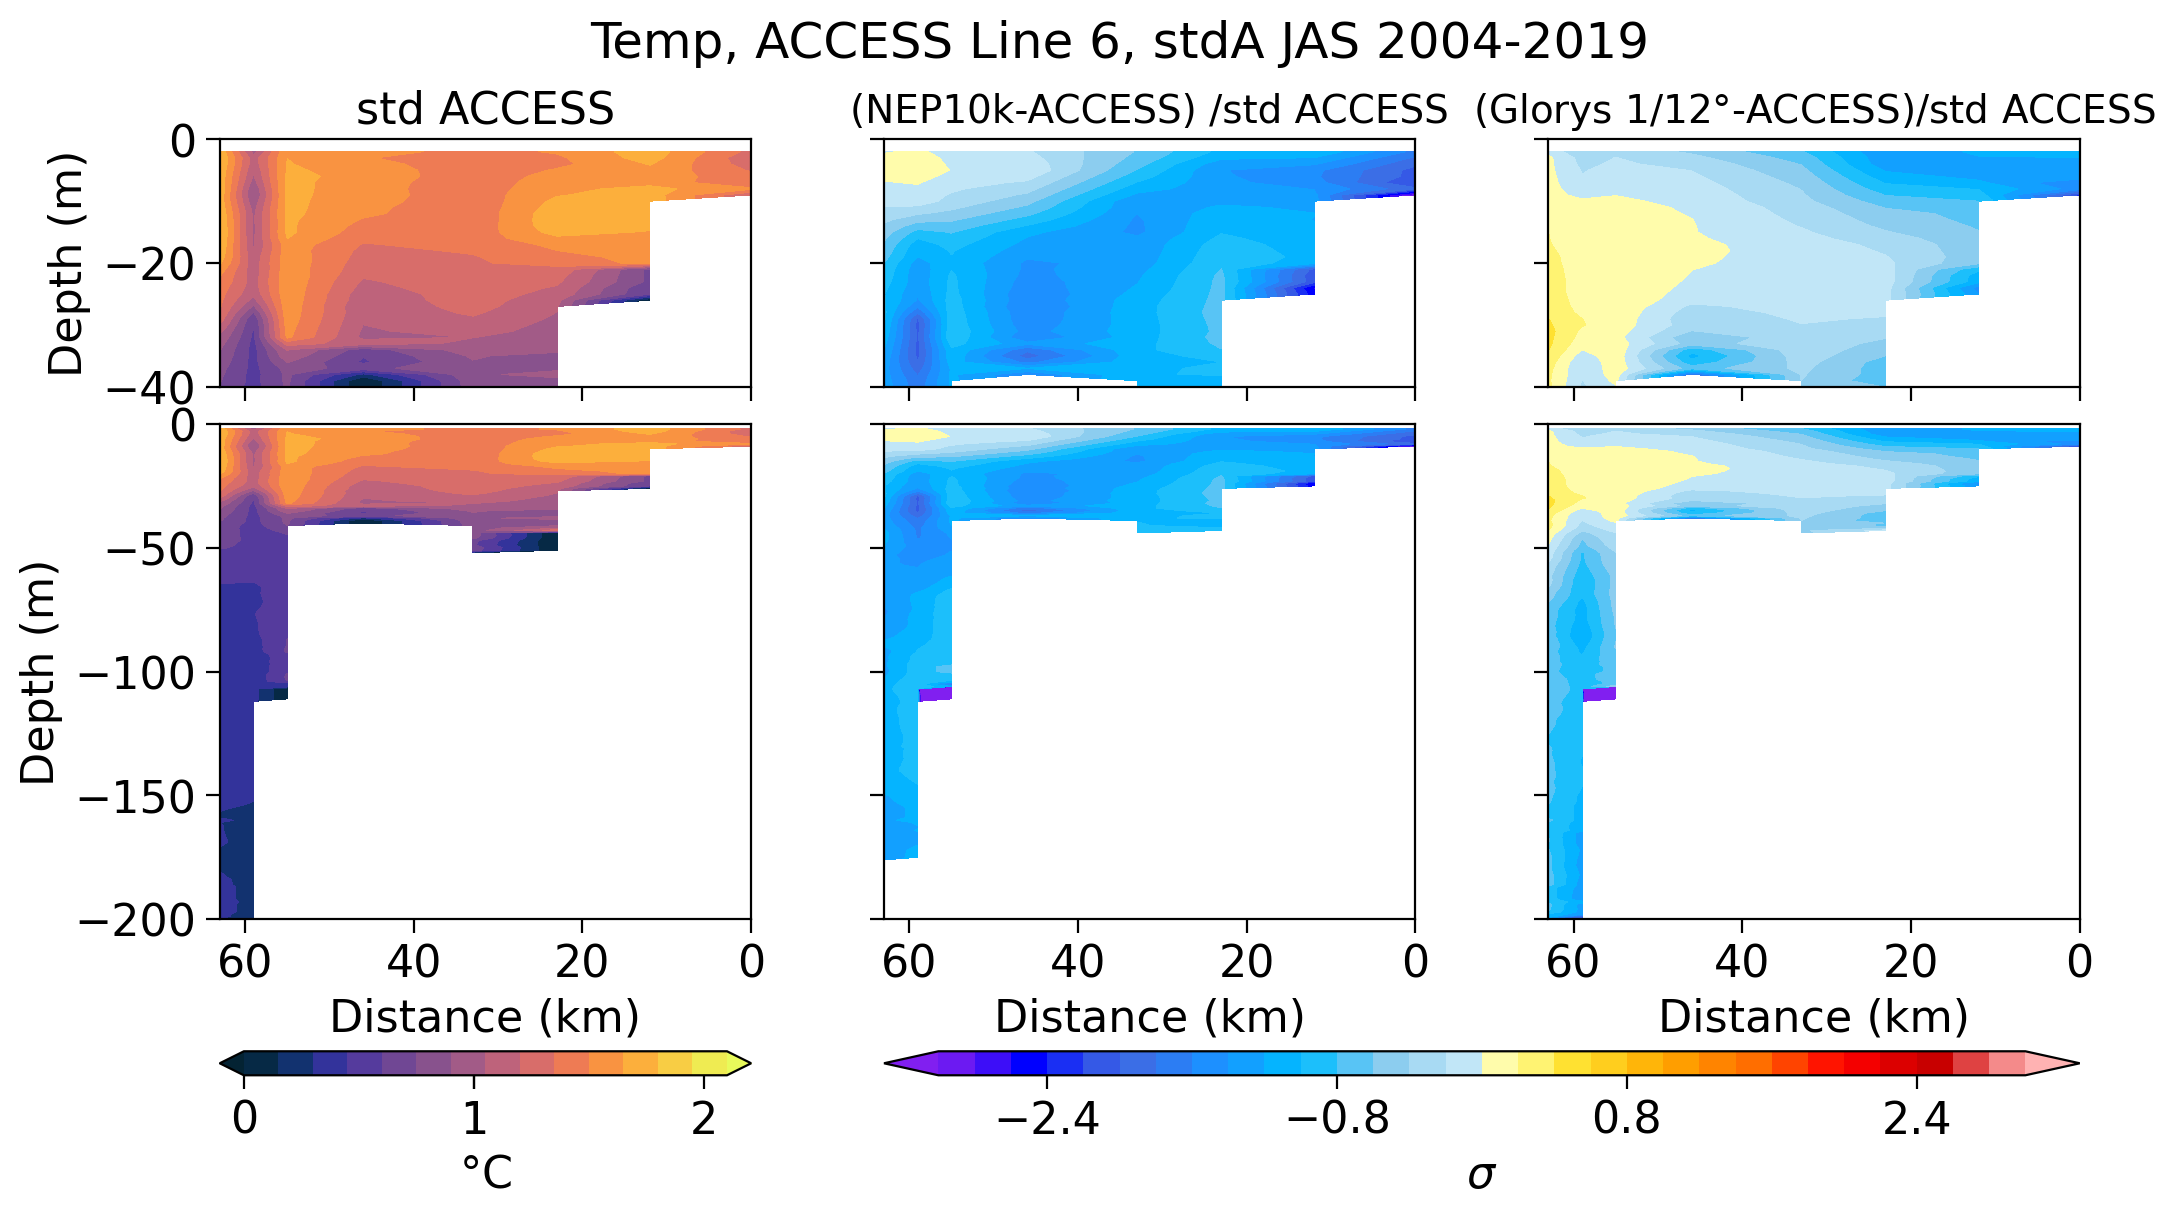

In [451]:
fig,axs=plt.subplots(nrows=2,ncols=3,gridspec_kw={'height_ratios':[3,6]},
                    figsize=(12,6),num=3,clear=True)
plt.subplots_adjust(bottom=0.23, right=0.9, top=0.88,hspace=0.1,wspace=0.25)
axs=axs.flatten()
cs =\
axs[0].contourf(-crossD,-dep,stdC,levels=clevss,extend='both',cmap='cmo.thermal',add_colorbar = False)
cs =\
axs[3].contourf(-crossD,-dep,stdC,levels=clevss,extend='both',cmap='cmo.thermal',add_colorbar = False)
axs[0].set_title(f'std {cruise}',fontsize=16)
cas=axs[1].contourf(-crossD,-dep,(meanN-meanC)/stdC,levels=clevssa,extend='both',cmap=cmaps.ncl_default,add_colorbar = False)
cas=axs[4].contourf(-crossD,-dep,(meanN-meanC)/stdC,levels=clevssa,extend='both',cmap=cmaps.ncl_default,add_colorbar = False)
axs[1].set_title(f'(NEP10k-{cruise}) /std {cruise}',fontsize=14)
axs[2].contourf(-crossD,-dep,(meanG-meanC)/stdC,levels=clevssa,extend='both',cmap=cmaps.ncl_default,add_colorbar = False)
axs[5].contourf(-crossD,-dep,(meanG-meanC)/stdC,levels=clevssa,extend='both',cmap=cmaps.ncl_default,add_colorbar = False)
axs[2].set_title(f'(Glorys $1/12\degree$-{cruise})/std {cruise}',fontsize=14)
for ix in range(0,len(axs)):
    axs[ix].set_ylabel('')
    axs[ix].set_xlabel('')
    if ix<3:
      axs[ix].set_ylim(-40,0)
      axs[ix].set_xticklabels([''])
      axs[ix].set_xlabel('',size=12)
    else:
      axs[ix].set_ylim(-200,0)
      axs[ix].set_xticklabels([f'{int(abs(ixx))}' \
          for ixx in axs[ix].get_xticks()[:]],fontsize=16)
      axs[ix].set_xlabel('Distance (km)',size=16)
    if (ix==0) | (ix==3):
      axs[ix].yaxis.set_tick_params(labelsize=16)
      axs[ix].set_ylabel('Depth (m)',size=16)
    else:
      axs[ix].set_yticklabels([''])
p0 = axs[0].get_position().get_points().flatten()
cbar_ax=fig.add_axes([p0[0], 0.1, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label=units)
cbar.ax.set_xticks([round(ix) for ix in cbar.ax.get_xticks()[::2]])
cbar.set_label(label=units,fontsize=16)
cbar.ax.tick_params(labelsize=16)
p0 = axs[1].get_position().get_points().flatten()
p2 = axs[2].get_position().get_points().flatten()
cbar_ax=fig.add_axes([p0[0], 0.1, p2[2]-p0[0], 0.02])
cbar=fig.colorbar(cas, cax=cbar_ax,orientation='horizontal')
cbar.ax.set_xticks(cbar.ax.get_xticks()[::2])#,labelsize=12)
cbar.set_label(label='$\sigma$',fontsize=16)
cbar.ax.tick_params(labelsize=16)
plt.suptitle(f'{var}, {cruise} Line {iline}, stdA JAS 2004-2019',fontsize=18)
outfile=f'PLOTS/{cruise}_JAS_STDA{var}_line{iline}_Xsection.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Read the full time

In [452]:
df=DS['time']
obs=DS['obs'].sel(depth=slice(0,200))
glo=DS['GLORYS'].sel(depth=slice(0,200))
nep=DS['NEP'].sel(depth=slice(0,200))


# Frequency Plot

/tmp/ipykernel_3876805/3174026905.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ix].set_xticklabels(axs[ix].get_xticklabels(),rotation=45,fontsize=14)


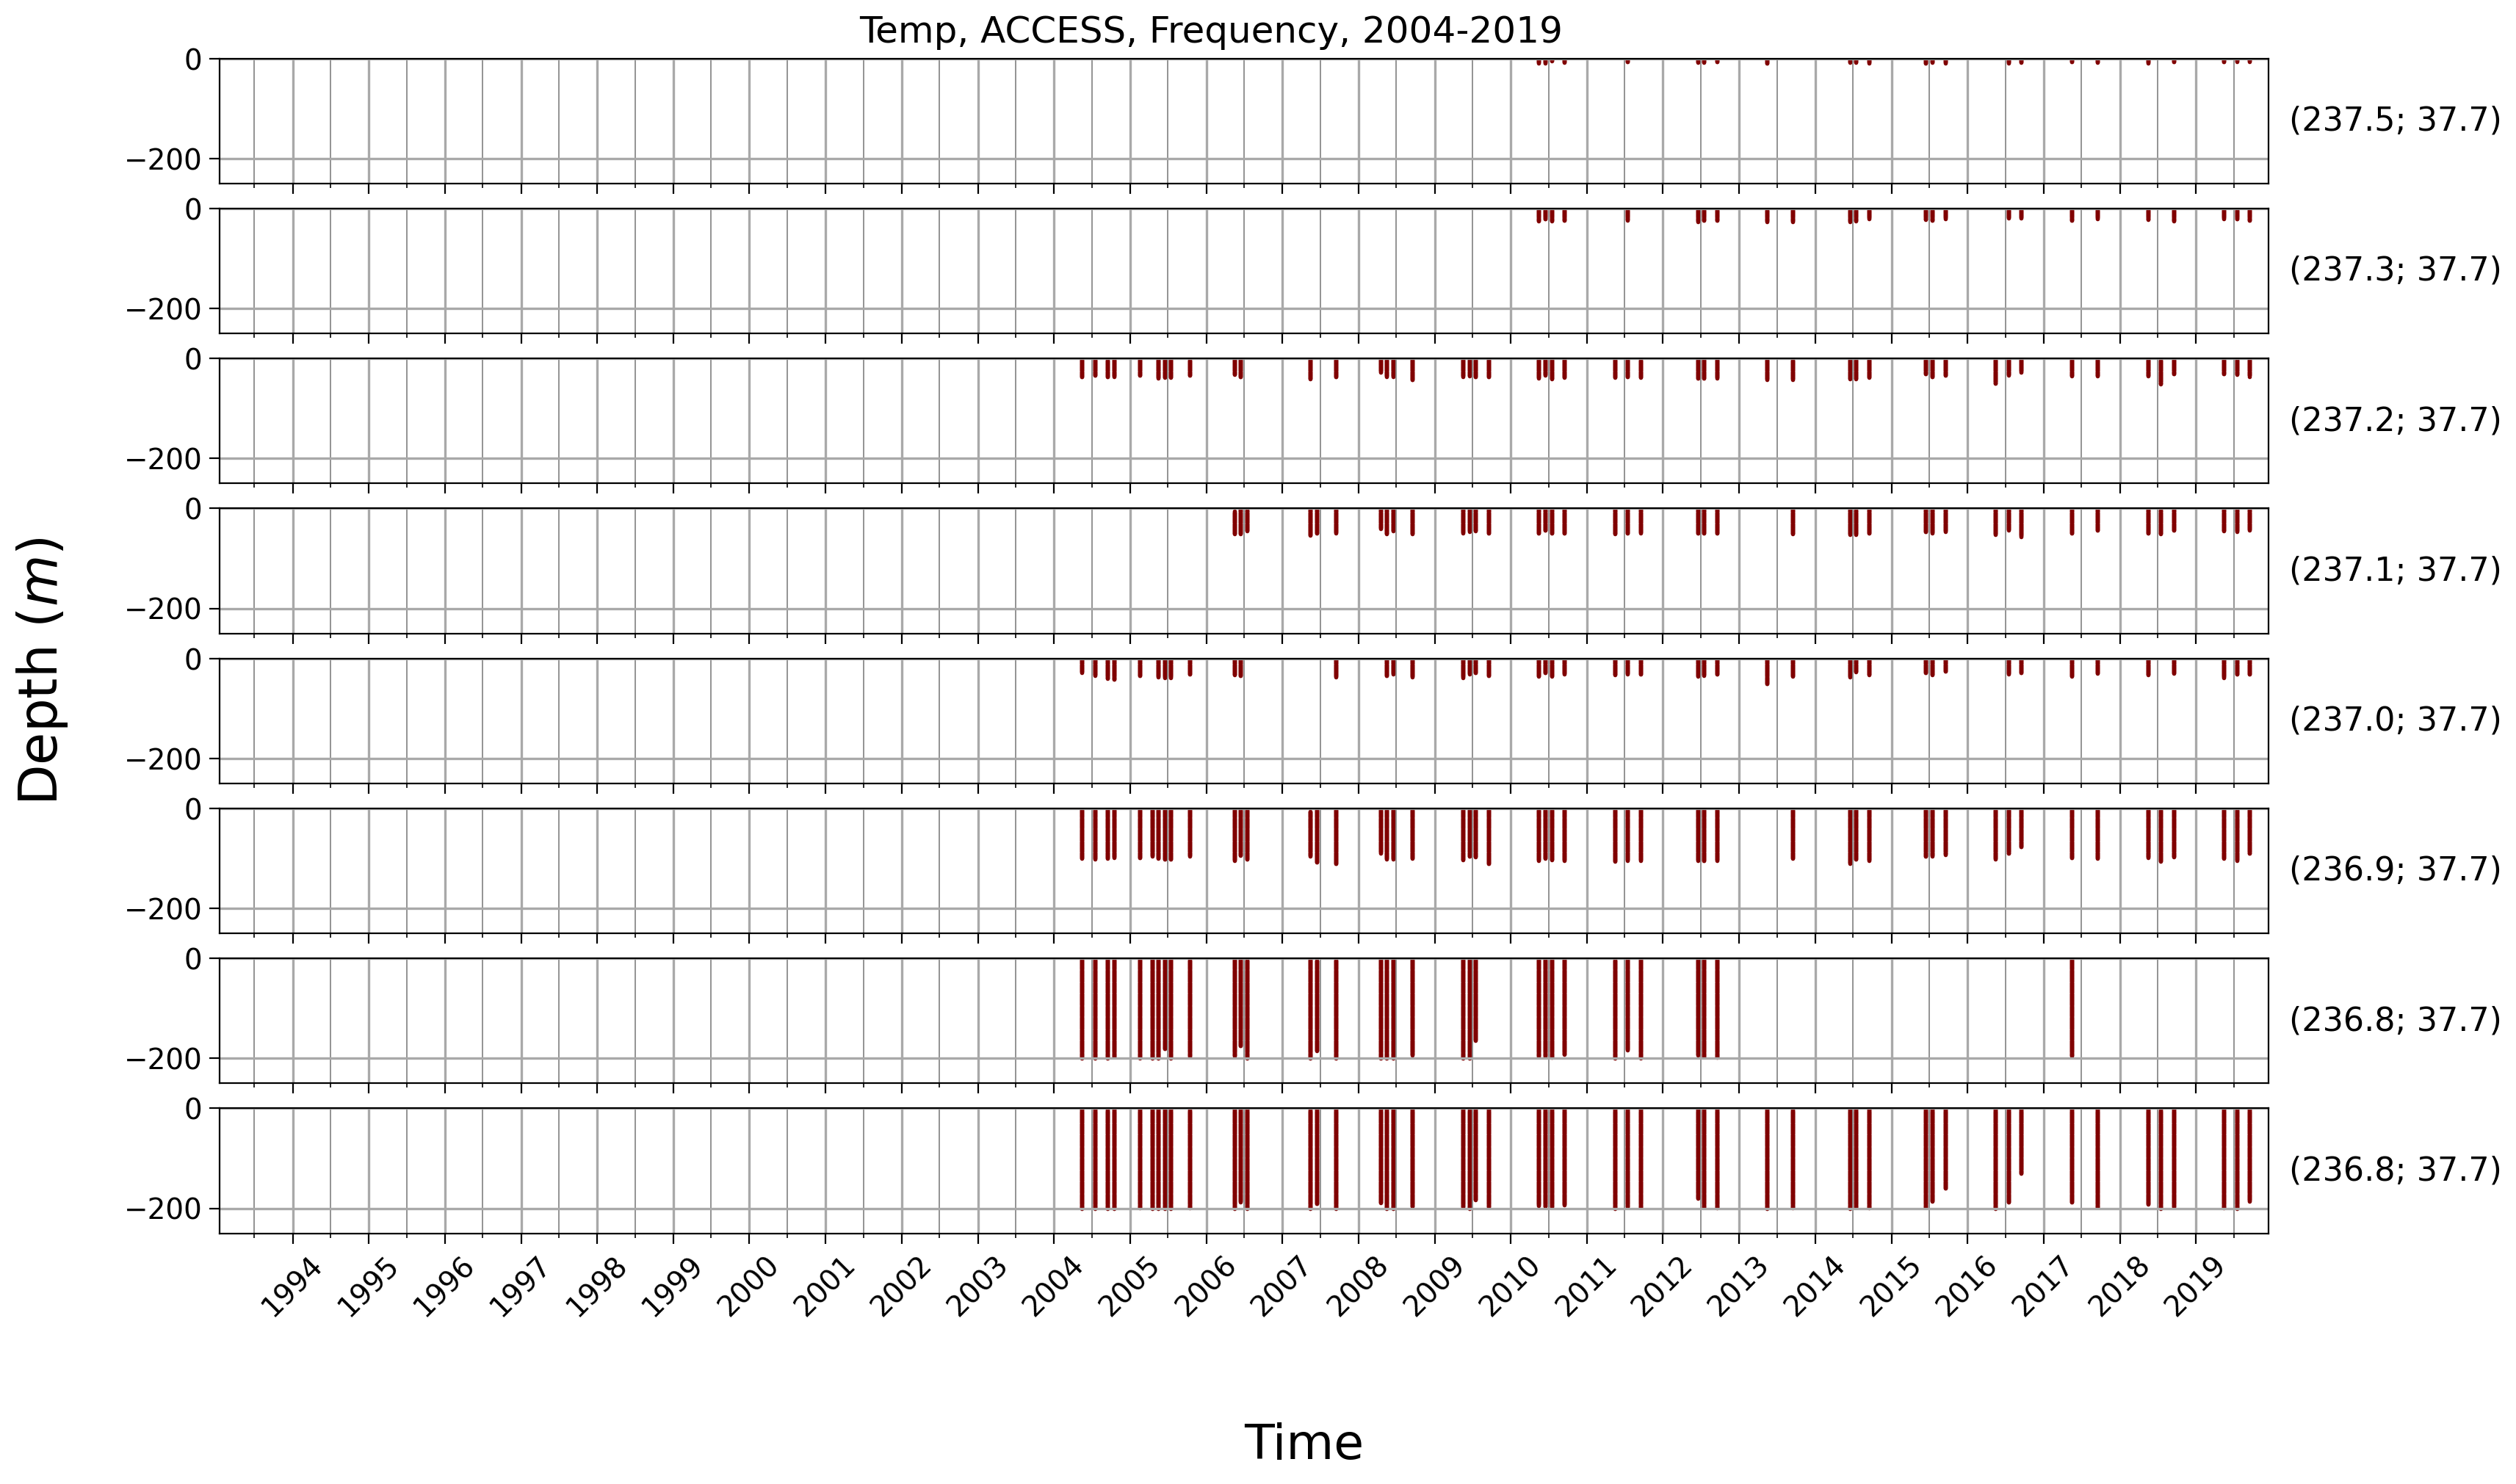

In [453]:
statimedepth=xr.ones_like(obs).where(np.isnan(obs)==False)
fig, axs =\
plt.subplots(nrows=len(DS['npts']),ncols=1,
                    figsize=(18,10),num=5,clear=True)
plt.subplots_adjust(bottom=0.15, right=0.9, top=0.95,hspace=0.2)
for ix in range(0,len(DS['npts'])):
  idtime,iddep=np.where(statimedepth[:,:,ix]==1)
  ccT=axs[ix].scatter(DS['time'][idtime],-dep[iddep],s=1,c='maroon')
  plt.text(1.01, 0.5, f'(%1.1f; %1.1f)'%(DS['longitude'].values[ix],DS['latitude'].values[ix]),\
                transform=axs[ix].transAxes,\
            rotation='horizontal',va='center',fontsize=16)
  axs[ix].set_ylim(-250,0)
  axs[ix].set_title('')
  axs[ix].xaxis.set_minor_locator(mdates.MonthLocator(7))
  axs[ix].xaxis.set_major_locator(mdates.YearLocator(month=1))
  axs[ix].grid(which='major', color='darkgrey', linewidth=1.2)
  axs[ix].grid(which='minor', color='grey', linewidth=0.6)
  axs[ix].set_xlim(df[0],df[-1])
  axs[ix].set_yticks([-200,0])
  axs[ix].set_yticklabels(axs[ix].get_yticklabels(),fontsize=14)
  if ix==len(DS['npts'])-1:
    axs[ix].set_xticklabels(axs[ix].get_xticklabels(),rotation=45,fontsize=14)
  else:
    axs[ix].set_xticklabels('')
plt.text(-0.1, 0.9, f'Depth ($m$)',transform=axs[round(len(DS['npts'])/2)].transAxes,\
            rotation='vertical',va='center',fontsize=26)
plt.text(0.5, -1.7, f'Time',transform=axs[len(DS['npts'])-1].transAxes,\
            va='center',fontsize=24)
plt.suptitle(f'{var}, {cruise}, Frequency, 2004-2019')
outfile=f'PLOTS/{cruise}_{var}_line{iline}_frequency.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

Get the number of data per month

In [454]:
xxx=df[idtime].sel(time=slice('2004-01-01','2019-12-31')).dt.month.data
np.unique(list(xxx))
for ix in np.unique(list(xxx)):
  list(xxx).count(ix)
  print(ix,list(xxx).count(ix))

2 198
4 387
5 2556
6 1742
7 2334
9 2635
10 396


/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


# Plot Taylor Diagram

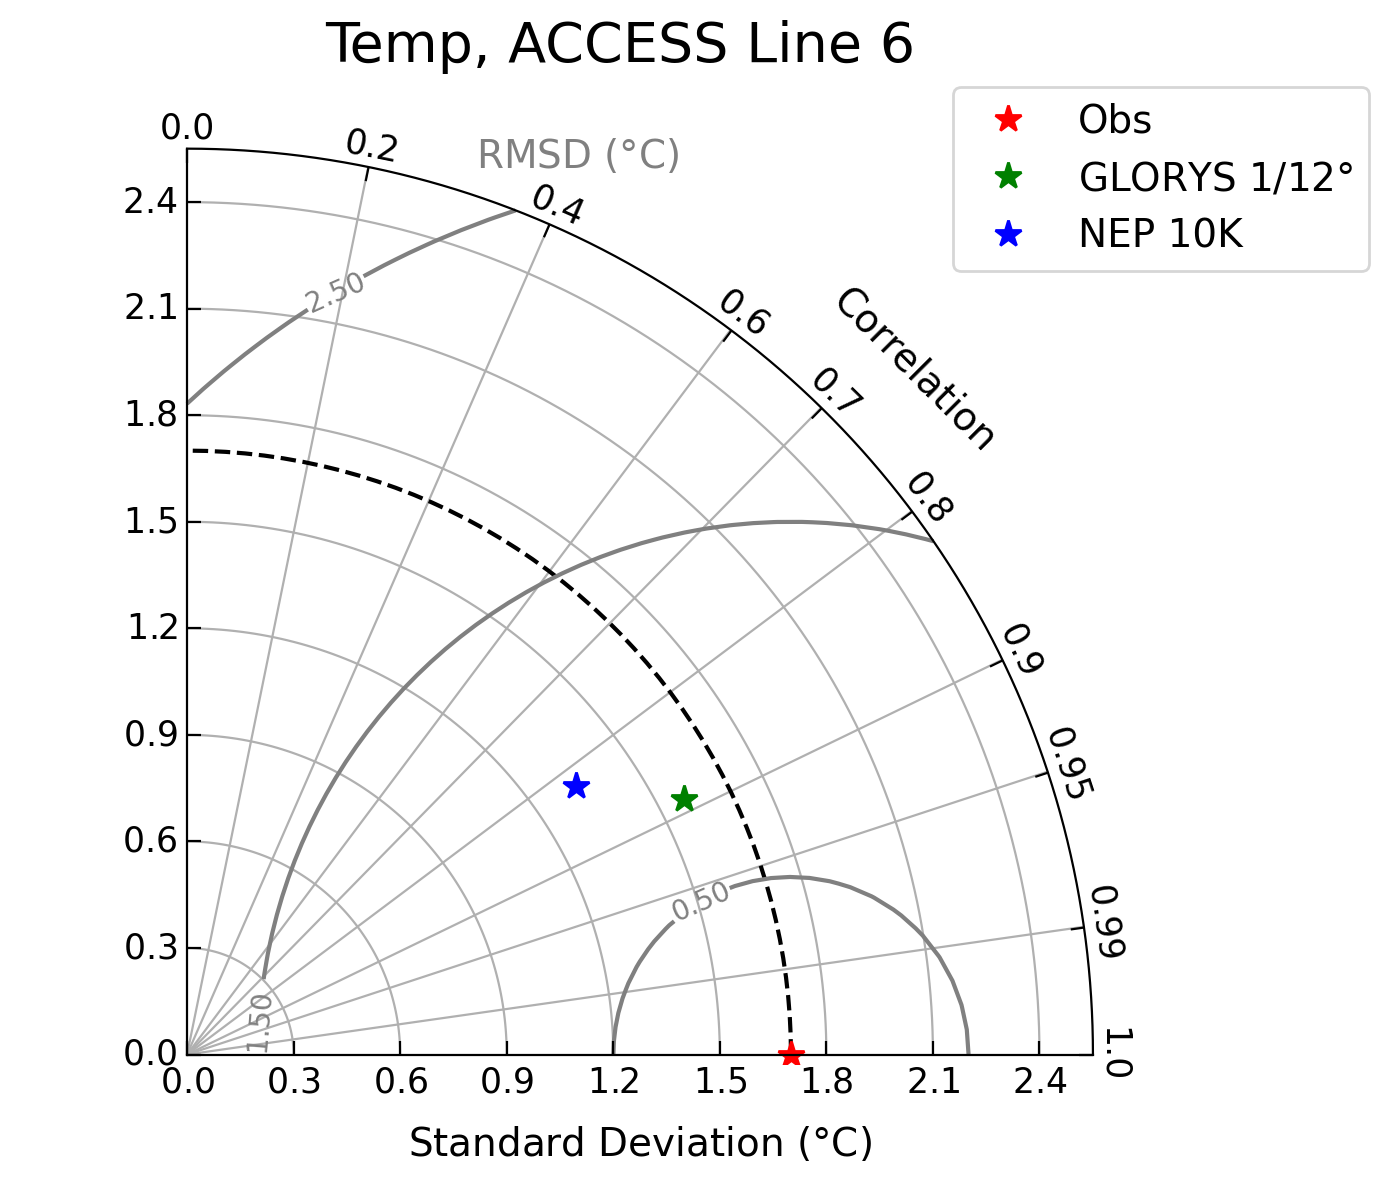

In [ ]:
xxx=np.where(np.isnan(obs.data.flatten())==False)[0]
xxx1=np.where(np.isnan(glo.data.flatten())==False)[0]
xxx2=np.where(np.isnan(nep.data.flatten())==False)[0]
yyy=list(set(set(xxx).intersection(xxx1)).intersection(xxx2))

# Reference dataset
dataC=obs.data.flatten()[yyy]
# Generate models
m1C = glo.data.flatten()[yyy]  # Model 1
m2C = nep.data.flatten()[yyy]  # Model 2

samples = np.array([ [m.std(ddof=1), np.corrcoef(dataC,m)[0, 1]]
                       for m in (dataC,m1C, m2C)])


fig,axs = plt.subplots(nrows=1,ncols=1)
dia = utils.TaylorDiagram(samples[0,0], fig=fig, rect=111, label="",
                    srange=(0., 1.5))

colors = ['red','green','blue']
labels = ["Obs",'GLORYS $1/12\degree$','NEP 10K']
# Add the models to Taylor diagram
for i, (stddev, corrcoef) in enumerate(samples):
  dia.add_sample(stddev, corrcoef, \
                    marker='*', ms=10, ls='', \
                    mfc=colors[i], mec=colors[i], \
                    label=labels[i])
# Add grid
dia.add_grid()
# Add a figure legend
fig.legend(dia.samplePoints,
            [ p.get_label() for p in dia.samplePoints ],
            numpoints=1, loc='upper right',\
                    bbox_to_anchor=(0.98,0.94), prop={'size': 14})
plt.text(0.5,-0.1,f'Standard Deviation ({units})',c='k',transform=axs.transAxes,\
            ha='center',fontsize=14,rotation=0)
plt.text(0.65,0.75,f'Correlation',c='k',transform=axs.transAxes,\
            va='center',fontsize=14,rotation=315)
plt.text(0.45,0.97,f'RMSD ({units})',c='grey',transform=axs.transAxes,\
            rotation=0,ha='center',fontsize=14)
axs.axis('off')
plt.suptitle(f'{var}, {cruise} Line {iline}',fontsize=20)
outfile=f'PLOTS/{cruise}_{var}_line{iline}_TaylorDiagram.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Scatter Plot

/tmp/ipykernel_3876805/1118717333.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
/tmp/ipykernel_3876805/1118717333.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)


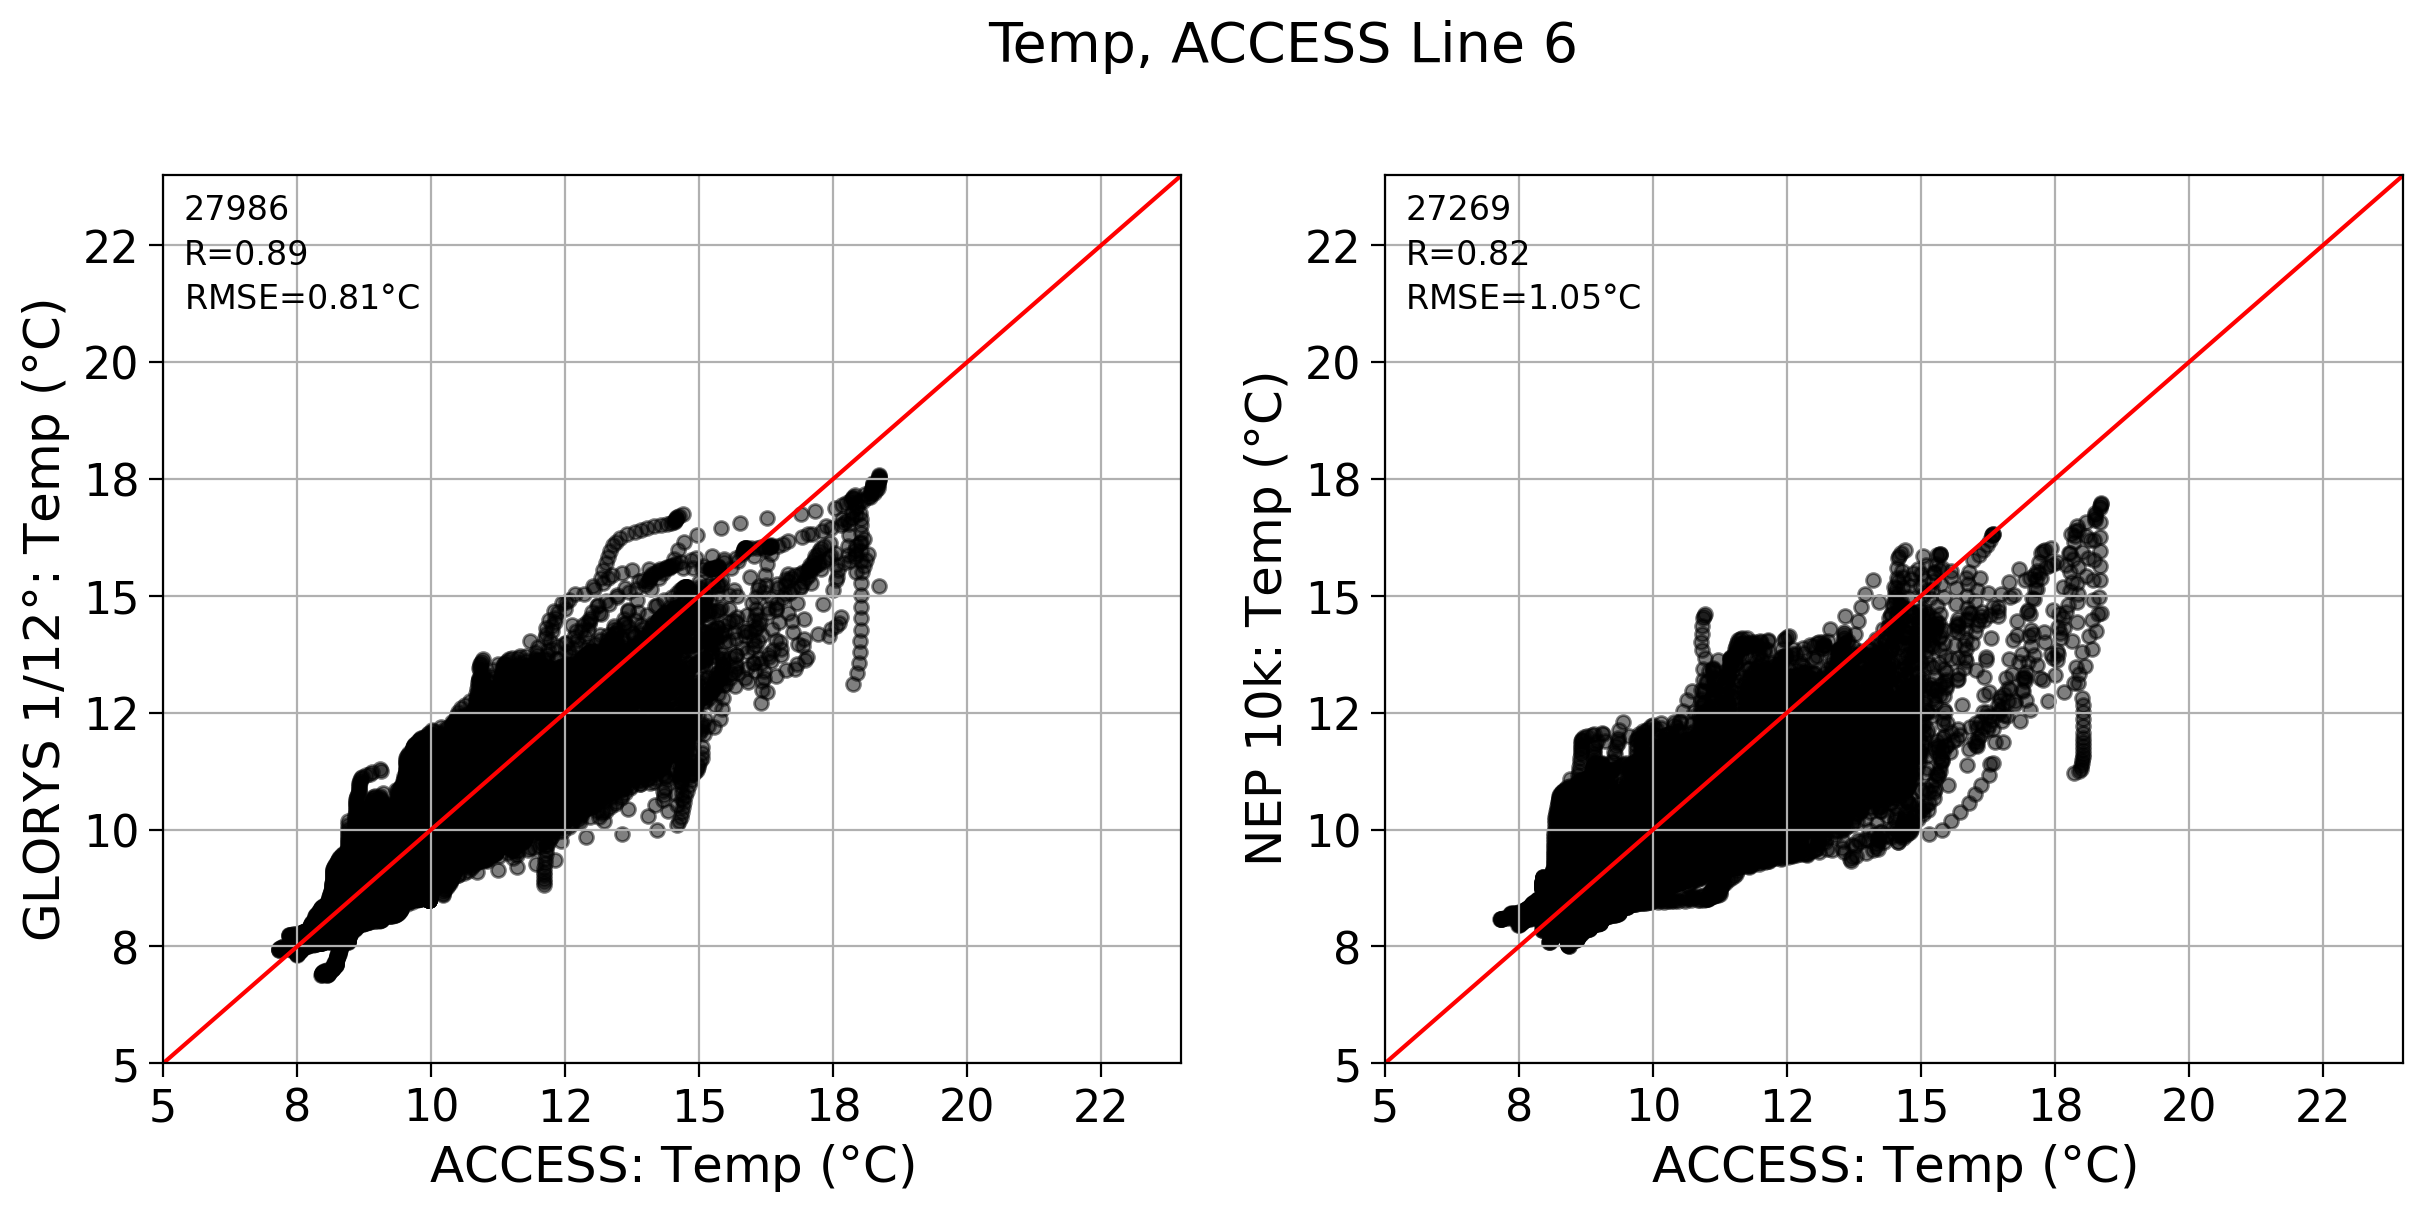

In [456]:
rmse_G=np.round(np.sqrt(((obs-glo)**2).mean().data),2)
rmse_N=np.round(np.sqrt(((obs-nep)**2).mean().data),2)
cor_G=np.round(np.corrcoef(obs.data.flatten()[xxx1],glo.data.flatten()[xxx1])[0][1],2)
cor_N=np.round(np.corrcoef(obs.data.flatten()[xxx2],nep.data.flatten()[xxx2])[0][1],2)

fig, axs =plt.subplots(nrows=1,ncols=2,figsize=(14,6),num=4,clear=True)

plt.subplots_adjust(bottom=0.11, right=0.9,left=0.1,top=0.85,wspace=0.2)

scatter=axs[0].scatter(obs,glo,s=25,c='k',marker='o',alpha=0.5)
scatter=axs[1].scatter(obs,nep,s=25,c='k',marker='o',alpha=0.5)
axs[0].text(0.02, 0.95,f'{len(xxx1)}',transform=axs[0].transAxes,\
            rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.9,f'R={cor_G}',transform=axs[0].transAxes,\
            rotation='horizontal',fontsize=12)
axs[0].text(0.02, 0.85,f'RMSE={rmse_G}{units}',transform=axs[0].transAxes,\
            rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.95,f'{len(xxx2)}',transform=axs[1].transAxes,\
            rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.90,f'R={cor_N}',transform=axs[1].transAxes,\
            rotation='horizontal',fontsize=12)
axs[1].text(0.02, 0.85,f'RMSE={rmse_N}{units}',transform=axs[1].transAxes,\
            rotation='horizontal',fontsize=12)

for i in range(len(axs)):
    axs[i].set_ylim(5,24)
    axs[i].set_xlim(5,24)
    axs[i].grid()
    axs[i].plot(np.arange(1,30,1),np.arange(1,30,1),color='red')
    axs[i].set_xticklabels([round(ix) for ix in axs[i].get_xticks()[:]],fontsize=16)
    axs[i].set_yticklabels([round(ix) for ix in axs[i].get_yticks()[:]],fontsize=16)
    axs[i].set_xlabel(f'{cruise}: {var} ({units})',fontsize=18)

axs[0].set_ylabel(f'GLORYS 1/12$\degree$: {var} ({units})',fontsize=18)
axs[1].set_ylabel(f'NEP 10k: {var} ({units})',fontsize=18)

plt.suptitle(f'{var}, {cruise} Line {iline}',fontsize=20)
outfile=f'PLOTS/{cruise}_{var}_line{iline}_Scatter.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

# Plot JAS time-series  

In [457]:
idep=5
ooo=obs.isel(depth=idep).resample(time='QS-JAN').mean('time',skipna=True)
nnn=nep.isel(depth=idep).resample(time='QS-JAN').mean('time',skipna=True)
ggg=glo.isel(depth=idep).resample(time='QS-JAN').mean('time',skipna=True)

AdataG=ggg.groupby('time.month')-ggg.groupby('time.month').mean('time',skipna=True)
AdataN=nnn.groupby('time.month')-nnn.groupby('time.month').mean('time',skipna=True)
AdataO=ooo.groupby('time.month')-ooo.groupby('time.month').mean('time',skipna=True)

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/tmp/ipykernel_3876805/746802500.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ix].set_yticklabels(axs[ix].get_yticklabels(),fontsize=16)
/tmp/ipykernel_3876805/746802500.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ix].set_xticklabels(axs[ix].get_xticklabels(),fontsize=16)


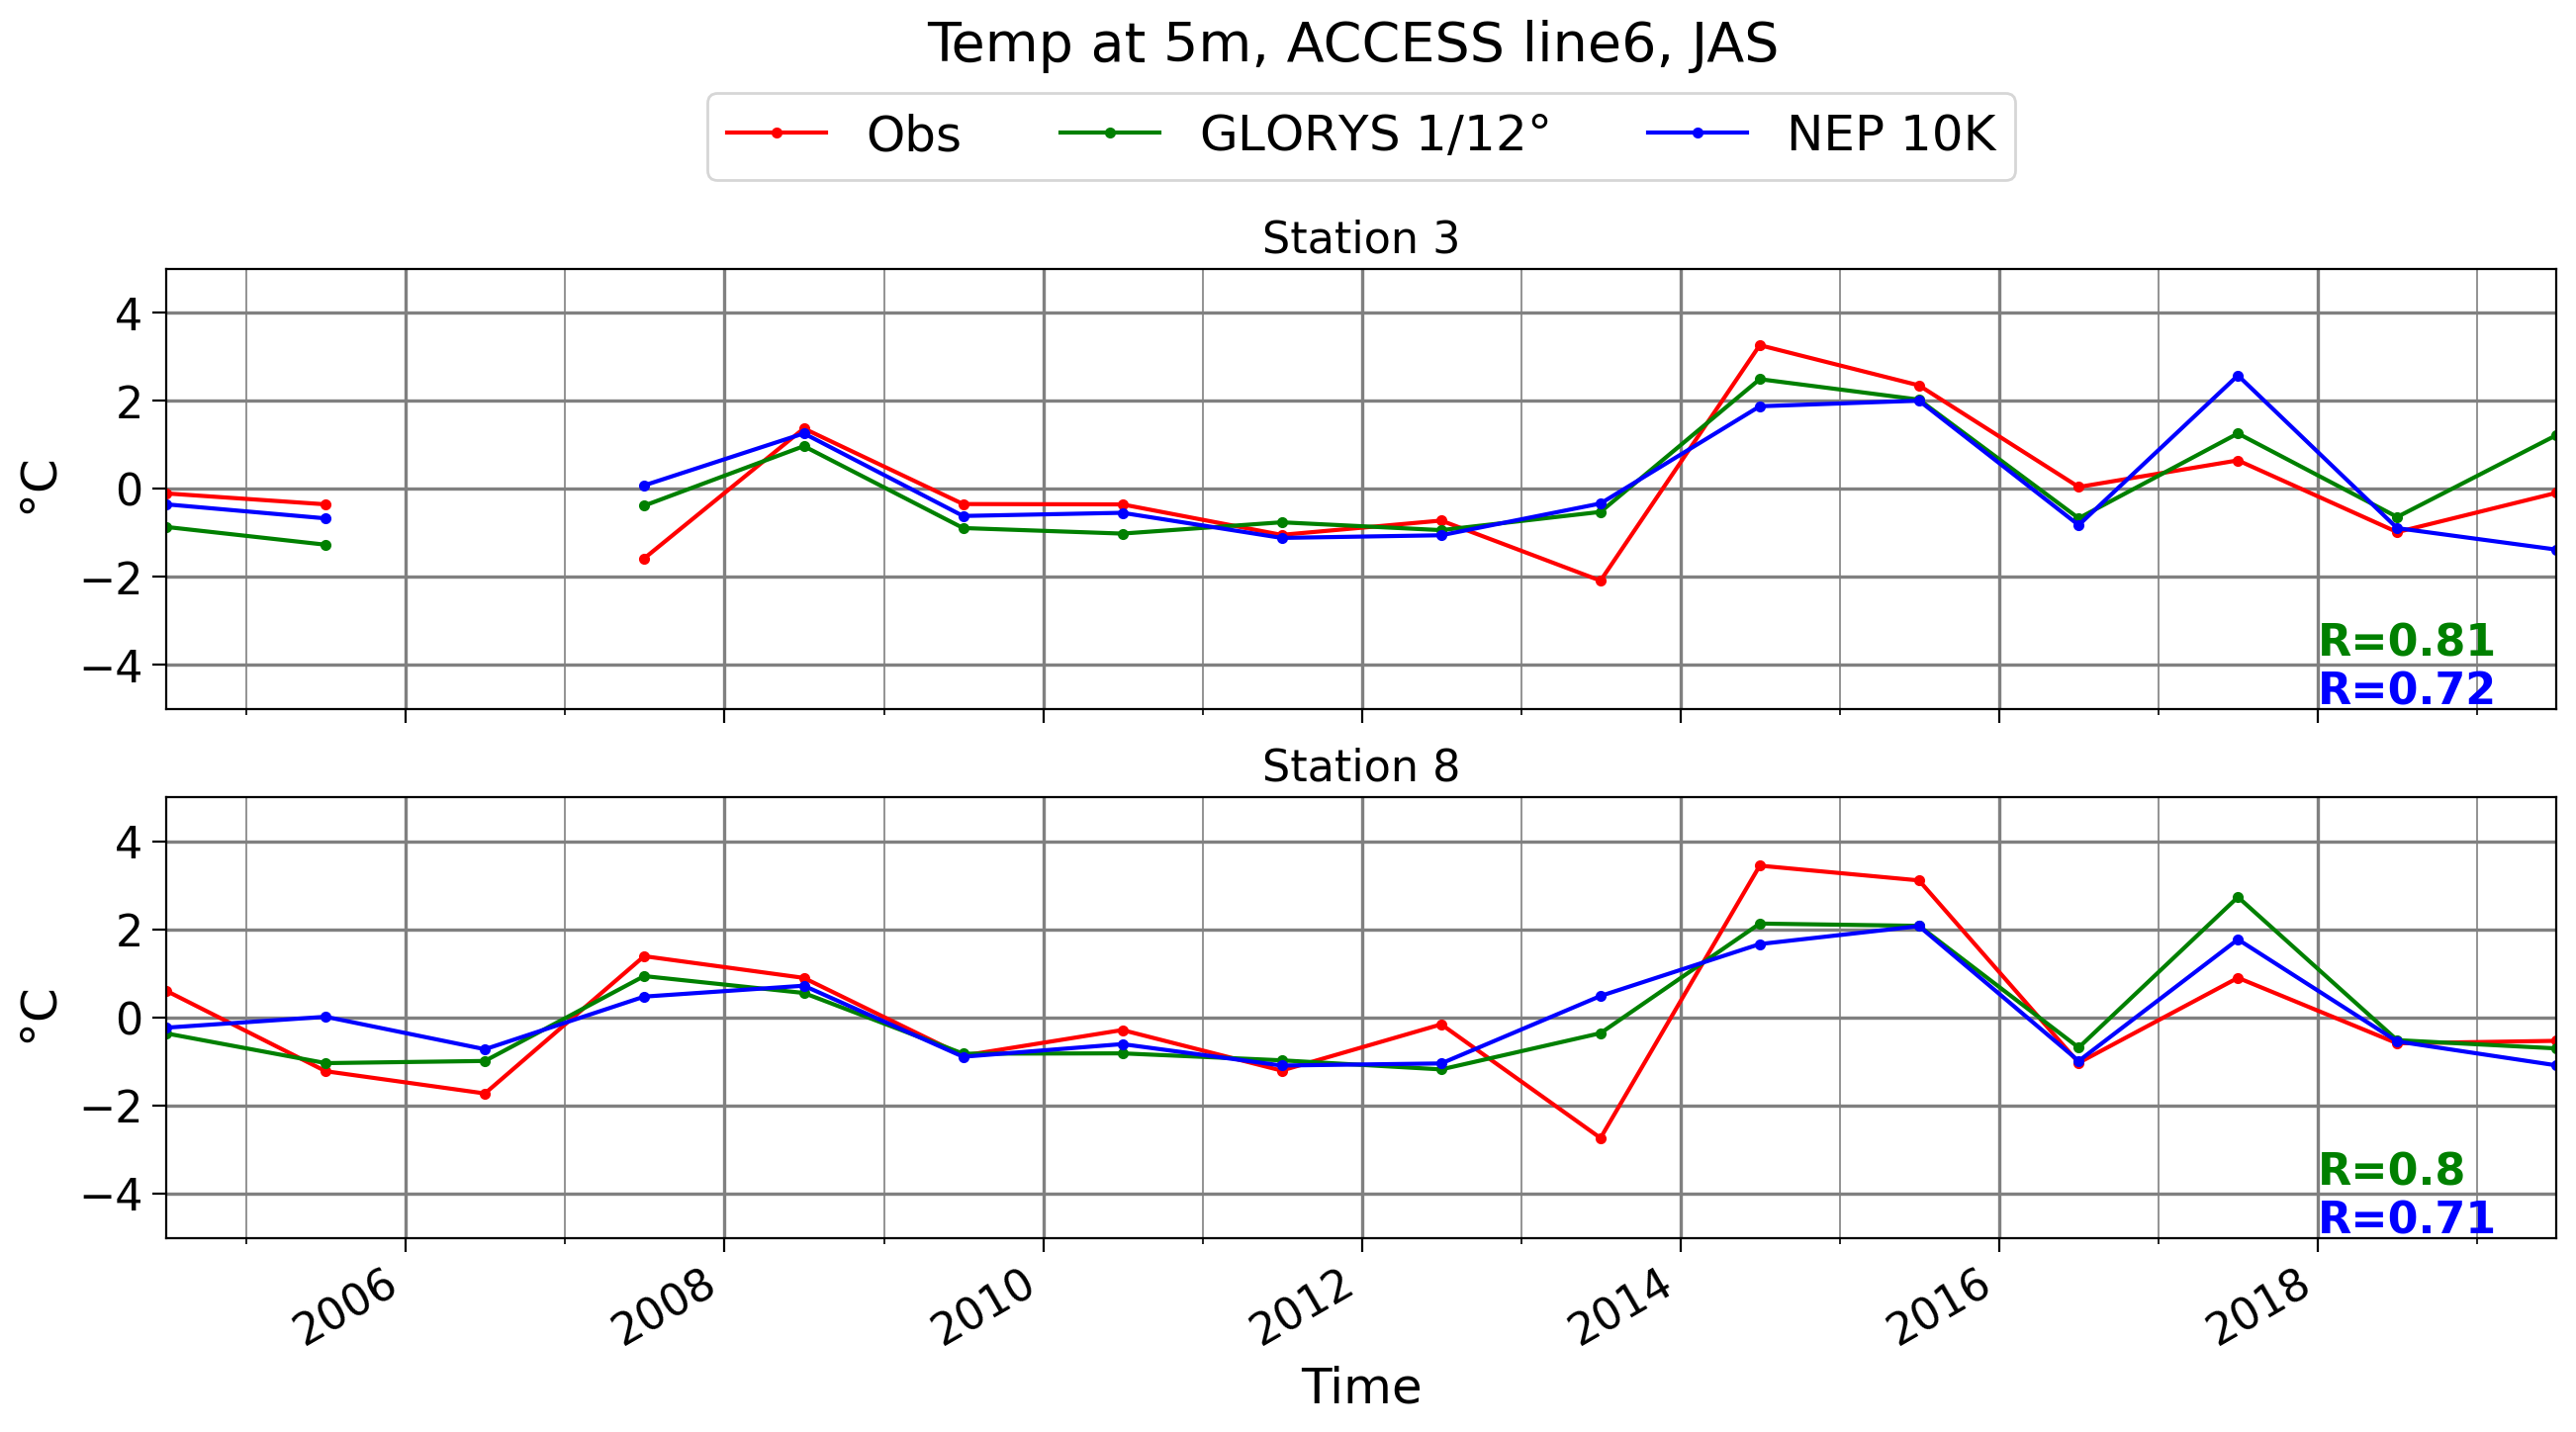

In [460]:
Vpt=[2,7]  # Chosen Stations 
fig, axs =\
plt.subplots(nrows=2,ncols=1,figsize=(16,7),clear=True)
plt.subplots_adjust(bottom=0.1, hspace=0.2,right=0.88, top=0.8)
axs=axs.flatten()
for ix in [0,1]:
    ipt=Vpt[ix]
    Oo=AdataO.isel(npts=ipt).sel(time=ooo.time.dt.month.isin([7]))
    Gg=AdataG.isel(npts=ipt).sel(time=ooo.time.dt.month.isin([7]))
    Nn=AdataN.isel(npts=ipt).sel(time=ooo.time.dt.month.isin([7]))
    xx1=np.where(np.isnan(Gg)==False)[0]
    xx2=np.where(np.isnan(Nn)==False)[0]
    cor_G=np.round(np.corrcoef(Oo[xx1],Gg[xx1])[0][1],2)
    cor_N=np.round(np.corrcoef(Oo[xx2],Nn[xx2])[0][1],2)
    Oo.plot.line(ax=axs[ix],c='r',marker='o',markersize=3,label='Obs')
    Gg.plot.line(ax=axs[ix],c='green',marker='o',markersize=3,label='GLORYS $1/12\degree$')
    Nn.plot.line(ax=axs[ix],c='blue',marker='o',markersize=3,label='NEP 10K')
    axs[ix].text(0.9, 0.12,f'R={cor_G}',c='green',transform=axs[ix].transAxes,\
                weight='bold',fontsize=16)
    axs[ix].text(0.9, 0.01,f'R={cor_N}',c='blue',transform=axs[ix].transAxes,\
                weight='bold',fontsize=16)
axs[0].legend(loc='center',ncols=3,\
                    bbox_to_anchor=(0.5,1.35), prop={'size': 18})
for ix in range(0,2):
    axs[ix].grid()
    axs[ix].set_ylim(-5.,5.)
    axs[ix].set_xlim(Oo.time[11],Oo.time[-1])
    axs[ix].set_title(f'Station {Vpt[ix]+1}',fontsize=16)
    axs[ix].set_ylabel('$\degree$C',size=18)
    axs[ix].xaxis.set_minor_locator(mdates.YearLocator(month=1))
    axs[ix].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axs[ix].grid(which='major', color='grey', linewidth=1.2)
    axs[ix].grid(which='minor', color='grey', linewidth=0.6)
    #axs[ix].set_yticks(axs[ix].get_yticks()[::2])
    axs[ix].set_yticklabels(axs[ix].get_yticklabels(),fontsize=16)
    if ix==1:
      axs[ix].set_xticklabels(axs[ix].get_xticklabels(),fontsize=16)
      axs[ix].set_xlabel('Time',size=18)
    else:
      axs[ix].set_xticklabels('',fontsize=16)
      axs[ix].set_xlabel('',size=18)
axs[0].legend(loc='center',ncol=3, bbox_to_anchor=(.5,1.3),\
    prop={'size': 18})
plt.suptitle(f'{var} at {idep}m, {cruise} line{iline}, JAS',fontsize=20)
outfile=f'PLOTS/{cruise}_JAS_A{var}_dep{idep}_Line{iline}_timeseries_resample.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')